# 🧠 VLM-Based Spike Sorting Curation & Merging Tutorial

This comprehensive tutorial demonstrates the complete workflow for:
1. **Generating synthetic neural data** with ground truth
2. **Running spike sorting** algorithms
3. **Curating units** using Vision-Language Models (VLM)
4. **Merging duplicate units** using VLM-based analysis

## Why VLM Curation?

Traditional spike sorting produces many putative neural units, but not all are real neurons. Some are:
- **Noise artifacts** (electrical interference, movement artifacts)
- **Multi-unit activity** (overlapping spikes from multiple neurons)
- **Duplicates** (same neuron detected multiple times)

VLM curation uses GPT-4o (or other vision-language models) to analyze visual representations of each unit and make intelligent decisions about unit quality and merge candidates.

---

## Table of Contents

1. [Setup & Imports](#1-setup--imports)
2. [Generate Synthetic Data](#2-generate-synthetic-data)
3. [Preprocess Recording](#3-preprocess-recording)
4. [Run Spike Sorting](#4-run-spike-sorting)
5. [Create Sorting Analyzer](#5-create-sorting-analyzer)
6. [Compute Analysis Extensions](#6-compute-analysis-extensions)
7. [Visualize Units](#7-visualize-units)
8. [VLM Curation](#8-vlm-curation)
9. [Apply Curation Results](#9-apply-curation-results)
10. [VLM Merge Analysis](#10-vlm-merge-analysis)
11. [Apply Merges](#11-apply-merges)
12. [Evaluate Results](#12-evaluate-results)

---

## 1. Setup & Imports

First, we import SpikeInterface, the core library for spike sorting analysis. We also configure parallel processing to use all available CPU cores for faster computation.

In [1]:
import spikeinterface.full as si
si.set_global_job_kwargs(n_jobs=-1)

---

## 2. Generate Synthetic Data

We use SpikeInterface's built-in synthetic data generator to create a ground truth recording. This allows us to validate our curation results against known "true" units.

**Parameters:**
- `num_channels=50`: Simulates a 50-channel electrode array
- `durations=[120.]`: 120 seconds of recording
- `num_units=30`: 30 ground truth neurons
- `seed=43`: Random seed for reproducibility

The function returns:
- `rec0`: The raw recording object
- `gt_sorting0`: Ground truth spike times for each unit

In [2]:
rec0, gt_sorting0 = si.generate_ground_truth_recording(num_channels=50, durations=[120.], seed=43, num_units=30)

### Visualize Raw Traces

Let's visualize a snippet of the raw recording to see the neural activity across channels.

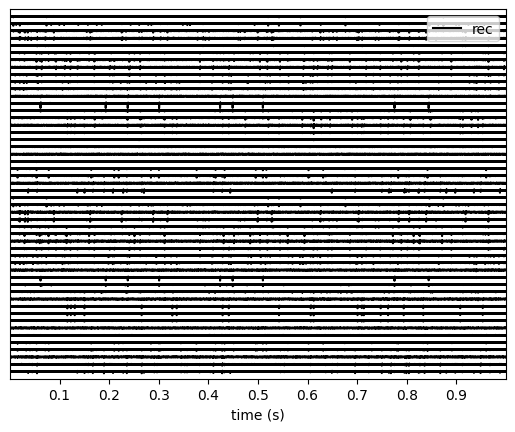

In [3]:
si.plot_traces(rec0)

---

## 3. Preprocess Recording

Raw neural recordings contain noise and artifacts that can interfere with spike detection. We apply two standard preprocessing steps:

### Step 3.1: Bandpass Filter

Filter the signal to retain frequencies between 300-6000 Hz, which captures the spike waveform frequency range while removing:
- **Low-frequency drift** (< 300 Hz): movement artifacts, respiration
- **High-frequency noise** (> 6000 Hz): electronic interference

In [4]:
rec0 = si.bandpass_filter(rec0, freq_min=300, freq_max=6000)

### Step 3.2: Common Average Reference (CAR)

Apply common median reference to remove global noise artifacts. This subtracts the median signal across all channels from each channel, effectively removing noise that appears on all electrodes simultaneously.

In [5]:
rec0 = si.common_reference(rec0, operator='median',reference= 'global')

---

## 4. Run Spike Sorting

Now we run the spike sorting algorithm to detect and cluster spikes. In this tutorial, we use **MountainSort4**, a fully automated spike sorting algorithm.

### Step 4.1: Configure Sorter

First, let's get the default parameters for MountainSort4.

In [6]:
sorter_name = "mountainsort4"
default_params = si.get_default_sorter_params(sorter_name)

### Step 4.2: Set Output Folder

Specify where to save the sorting results.

In [7]:
sorting_folder = "./moutainsort4_sorting"

### Step 4.3: Run the Sorter

Execute the spike sorting algorithm. This may take a few minutes depending on recording length and number of channels.

In [8]:
sorting = si.run_sorter(
    sorter_name=sorter_name,
    recording=rec0,
    folder=sorting_folder,
    remove_existing_folder=True,
    **default_params
)

Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording


sys:1: DeprecationWarning: Call to deprecated function (or staticmethod) _destroy.
sys:1: DeprecationWarning: Call to deprecated function (or staticmethod) _destroy.


### Step 4.4: Inspect Sorting Results

Let's examine the sorting output to see how many units were detected.

In [10]:
sorting

NpzSortingExtractor: 86 units - 1 segments - 25.0kHz
  file_path: /media/data0/spikeagent/revision/spikeagent_0.102.3_zuwan_test/testing_notebook/moutainsort4_sorting/sorter_output/firings.npz

### Step 4.5: Compare with Ground Truth (Pre-Curation)

Since we have synthetic data, we can compare the sorting results with the ground truth. This shows us:
- How many true units were found (matches on diagonal)
- How many false positives exist (extra units)
- How many units were missed (unmatched ground truth)

**Note:** The sorter typically produces more units than ground truth due to over-splitting and noise detection.

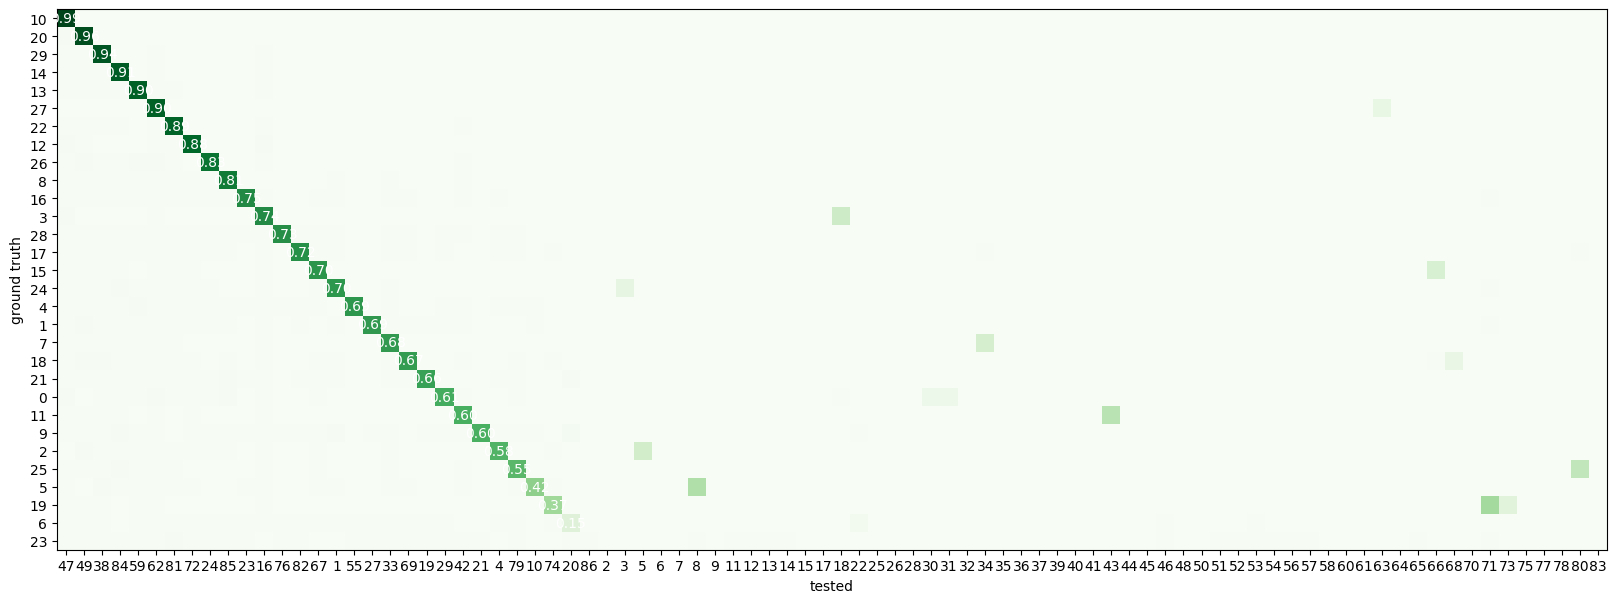

In [11]:
comp_gt = si.compare_sorter_to_ground_truth(gt_sorting=gt_sorting0, tested_sorting=sorting, exhaustive_gt=True)
si.plot_agreement_matrix(comp_gt, figsize=(20, 10))

---

## 5. Create Sorting Analyzer

The SortingAnalyzer is a container that links the sorting results with the recording and allows us to compute various analysis extensions.

First, add the project root to Python path to import custom tools.

In [12]:
import sys
import os

# Add the project root to the Python path to allow for package imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

Import our custom SpikeInterface extensions.

In [13]:
import tool.si_custom as sic

Create the SortingAnalyzer and save it in Zarr format for efficient storage and access.

In [14]:
analyzer_folder = sorting_folder + "/sorting_analyzer.zarr"
sorting_analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=rec0,
    format='zarr',
    folder=analyzer_folder,
    overwrite=True
)

estimate_sparsity (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

---

## 6. Compute Analysis Extensions

Now we compute various analysis extensions that will be used for:
1. **Visualization** - waveforms, templates, correlograms
2. **Quality metrics** - SNR, ISI violations, etc.
3. **VLM curation** - images for the vision-language model

### Extensions computed:

| Extension | Description |
|-----------|-------------|
| `random_spikes` | Sample spikes for waveform extraction |
| `waveforms` | Extract spike waveforms from raw data |
| `templates` | Average waveform templates per unit |
| `template_similarity` | Similarity matrix between unit templates |
| `spike_locations` | Spatial location of each spike |
| `unit_locations` | Estimated position of each unit |
| `isi_histograms` | Inter-spike interval distributions |
| `correlograms` | Auto/cross-correlograms |
| `spike_amplitudes` | Amplitude of each spike over time |
| `noise_levels` | Background noise estimation |
| `principal_components` | PCA of waveforms |
| `quality_metrics` | SNR, firing rate, ISI violations, etc. |

In [15]:
print("\n--- Starting Step 5: Computing analysis extensions ---")
extension_params = {
    "random_spikes": {"method": "uniform", "max_spikes_per_unit": 600},
    "waveforms": {"ms_before": 1.0, "ms_after": 2.0},
    "templates": {},
    "template_similarity": {},
    "spike_locations": {},
    "unit_locations": {},
    "isi_histograms": {"window_ms": 30, "bin_ms": 0.5, "method": "auto"},
    "correlograms": {"window_ms": 30, "bin_ms": 0.5, "method": "auto"},
    "spike_amplitudes": {},
    "noise_levels": {},
    "principal_components": {},
    "quality_metrics": {
        "metric_names": [
            "snr", "firing_rate", "isi_violation",
            "presence_ratio", "amplitude_cutoff", "amplitude_median", 'l_ratio', 'nearest_neighbor',
        ]
    }
}

for key, value in extension_params.items():
    print(f"Computing {key}...")
    extension = sorting_analyzer.get_extension(key)
    if extension is None or not value.items() <= extension.params.items():
        sorting_analyzer.compute(key, **value)
    else:
        print(f"{key} already computed with compatible parameters")

print("All extensions computed successfully.")
print("\n--- SortingAnalyzer after extension computation ---")
print(sorting_analyzer)


--- Starting Step 5: Computing analysis extensions ---
Computing random_spikes...
Computing waveforms...


compute_waveforms (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing templates...
Computing template_similarity...
Computing spike_locations...


spike_locations (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing unit_locations...
Computing isi_histograms...
Computing correlograms...
Computing spike_amplitudes...


spike_amplitudes (workers: 64 processes):   0%|          | 0/120 [00:00<?, ?it/s]

Computing noise_levels...


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Computing principal_components...


Fitting PCA:   0%|          | 0/86 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/86 [00:00<?, ?it/s]

Computing quality_metrics...


/home/arnau/miniconda3/envs/jongmin/lib/python3.11/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:910: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


calculate_pc_metrics:   0%|          | 0/86 [00:00<?, ?it/s]

All extensions computed successfully.

--- SortingAnalyzer after extension computation ---
SortingAnalyzer: 50 channels - 86 units - 1 segments - zarr - sparse - has recording
Loaded 12 extensions: random_spikes, waveforms, templates, template_similarity, spike_locations, unit_locations, isi_histograms, correlograms, spike_amplitudes, noise_levels, principal_components, quality_metrics


---

## 7. Visualize Units

Before running VLM curation, let's visualize some units to understand what the model will see.

We plot multiple features for each unit:
- **waveform_single**: Mean waveform on the peak channel
- **waveform_multi**: Waveforms across multiple channels
- **autocorr**: Autocorrelogram (refractory period check)
- **spike_locations**: Spatial distribution of spikes
- **amplitude_plot**: Spike amplitude stability over time

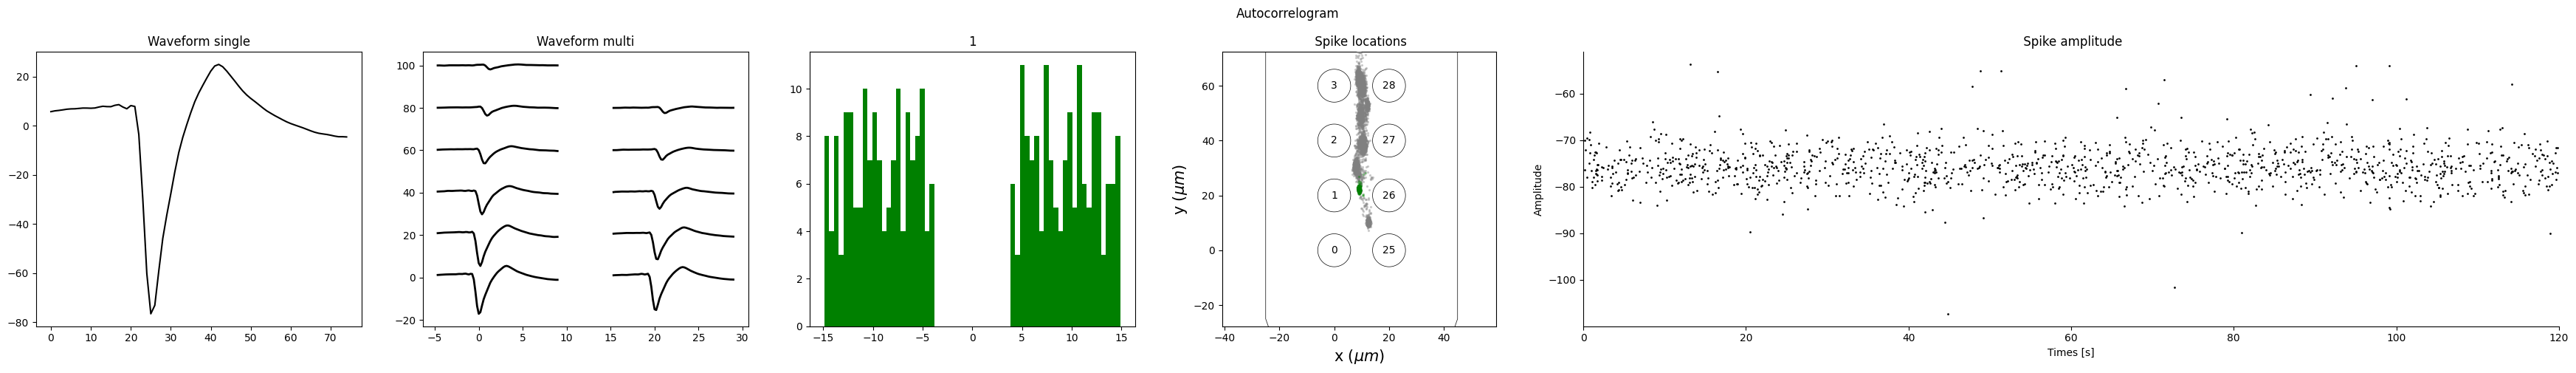

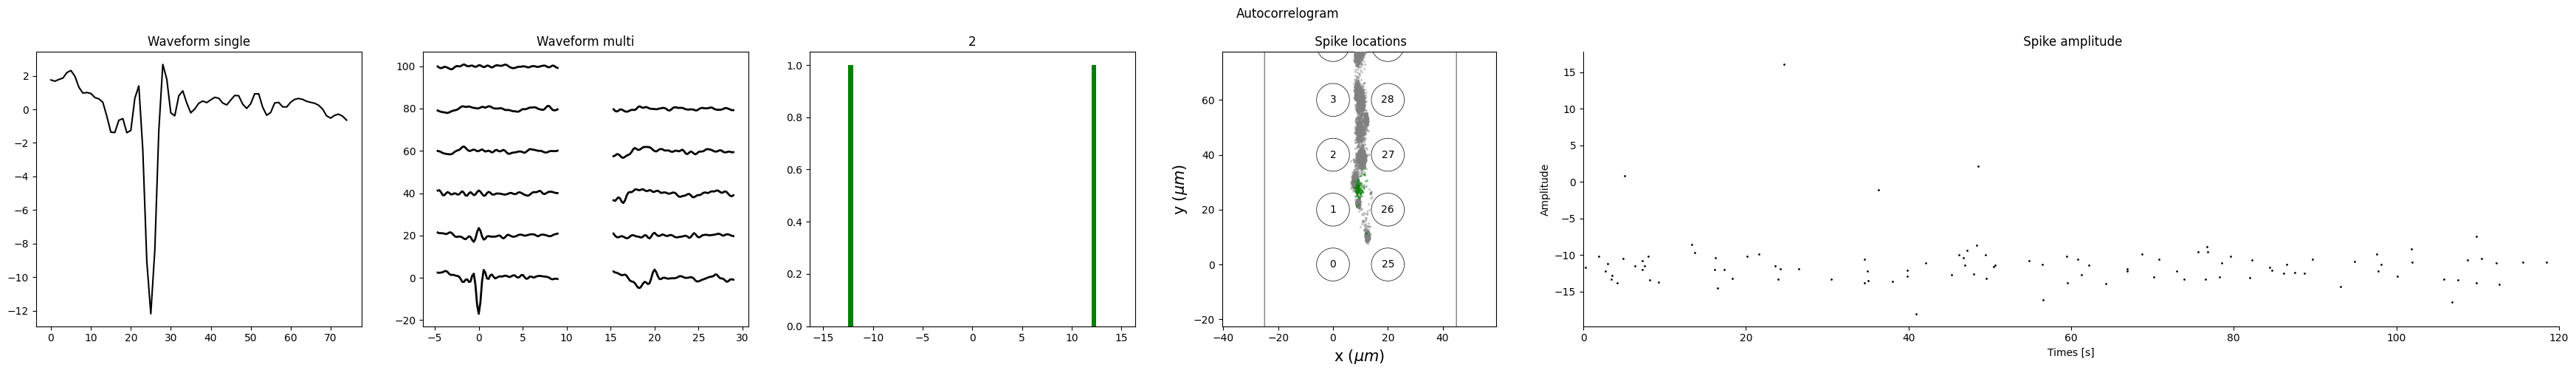

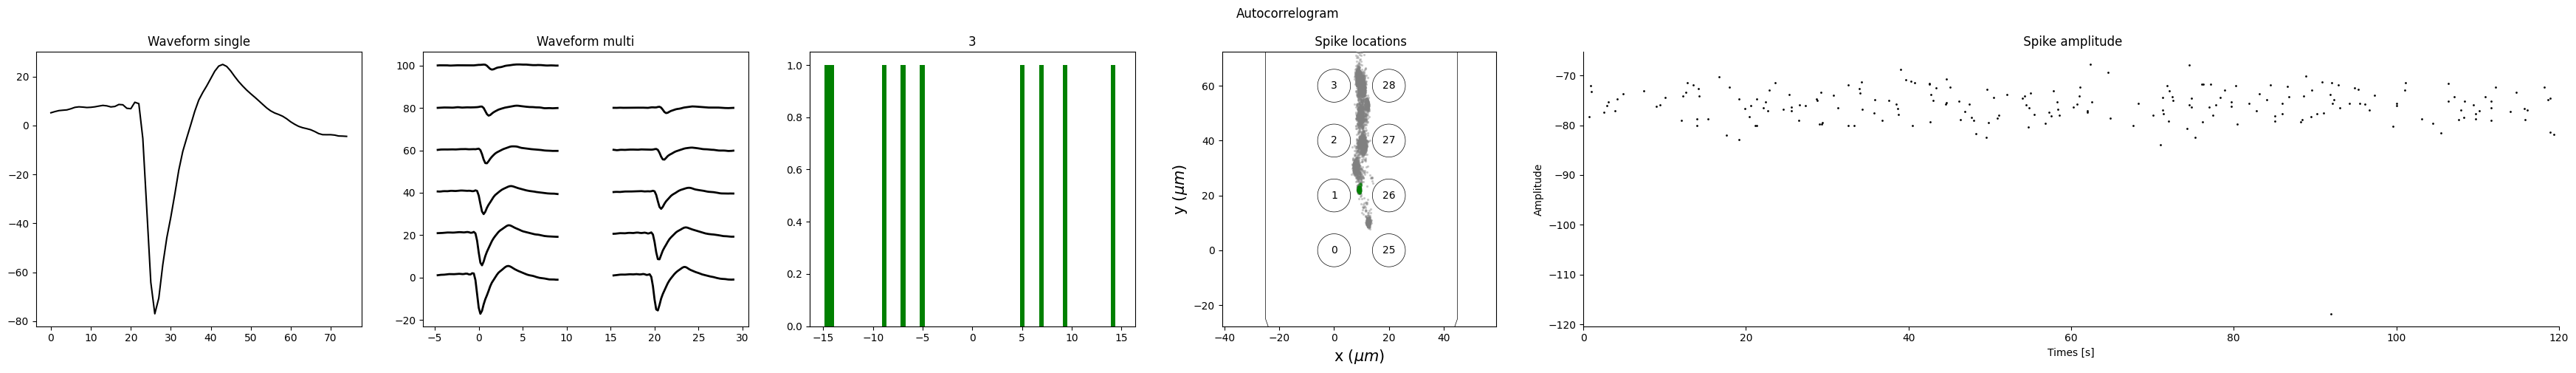

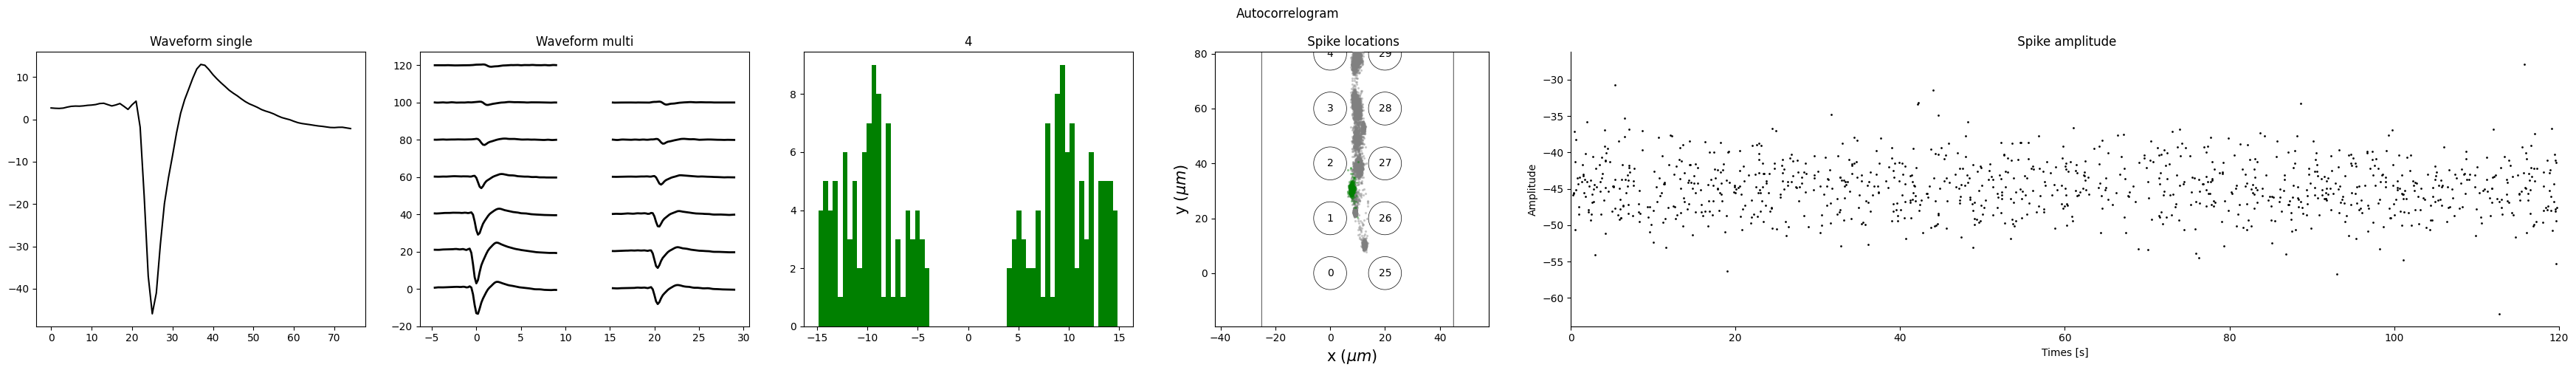

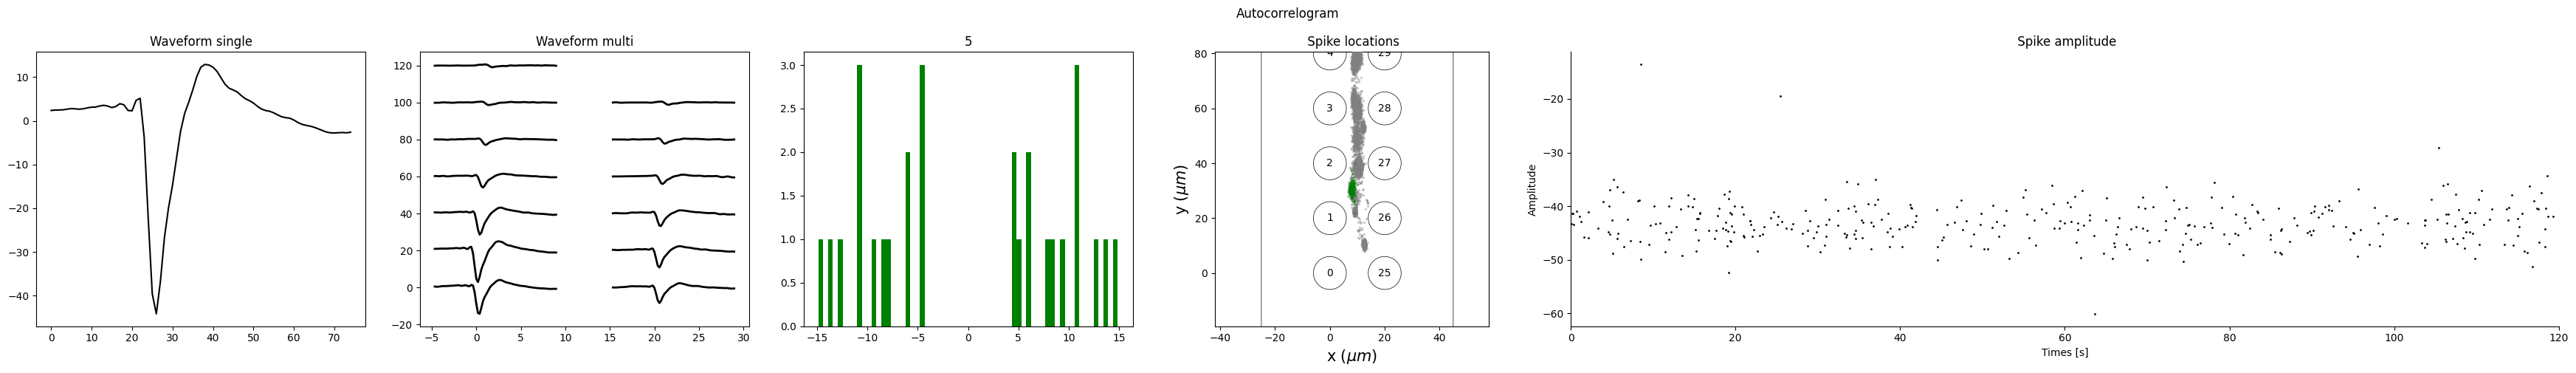

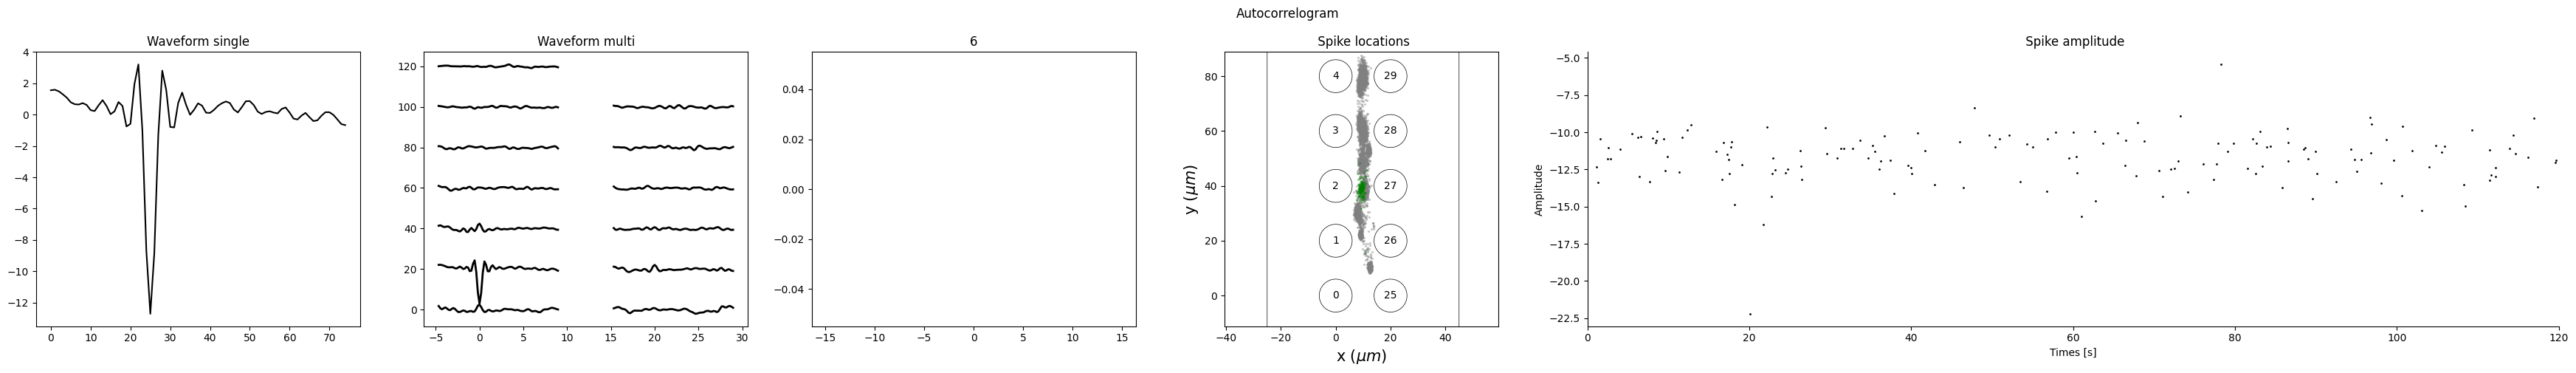

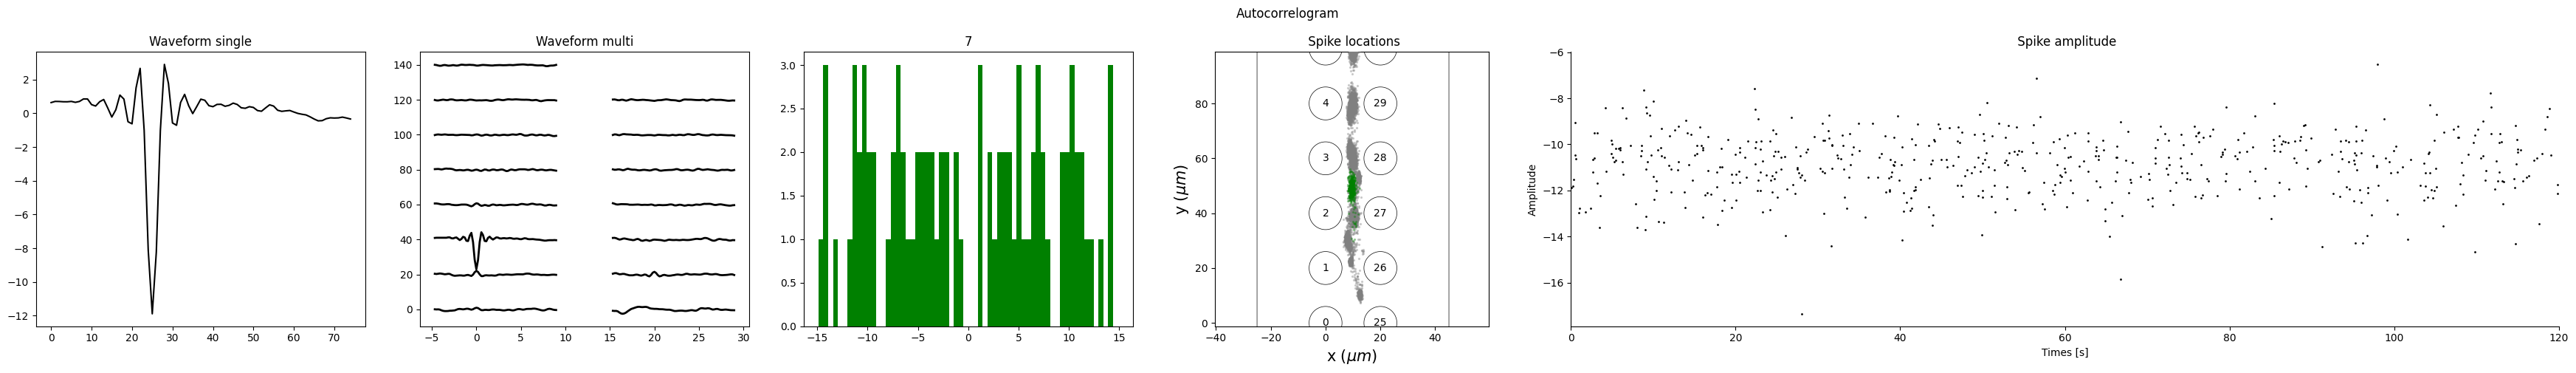

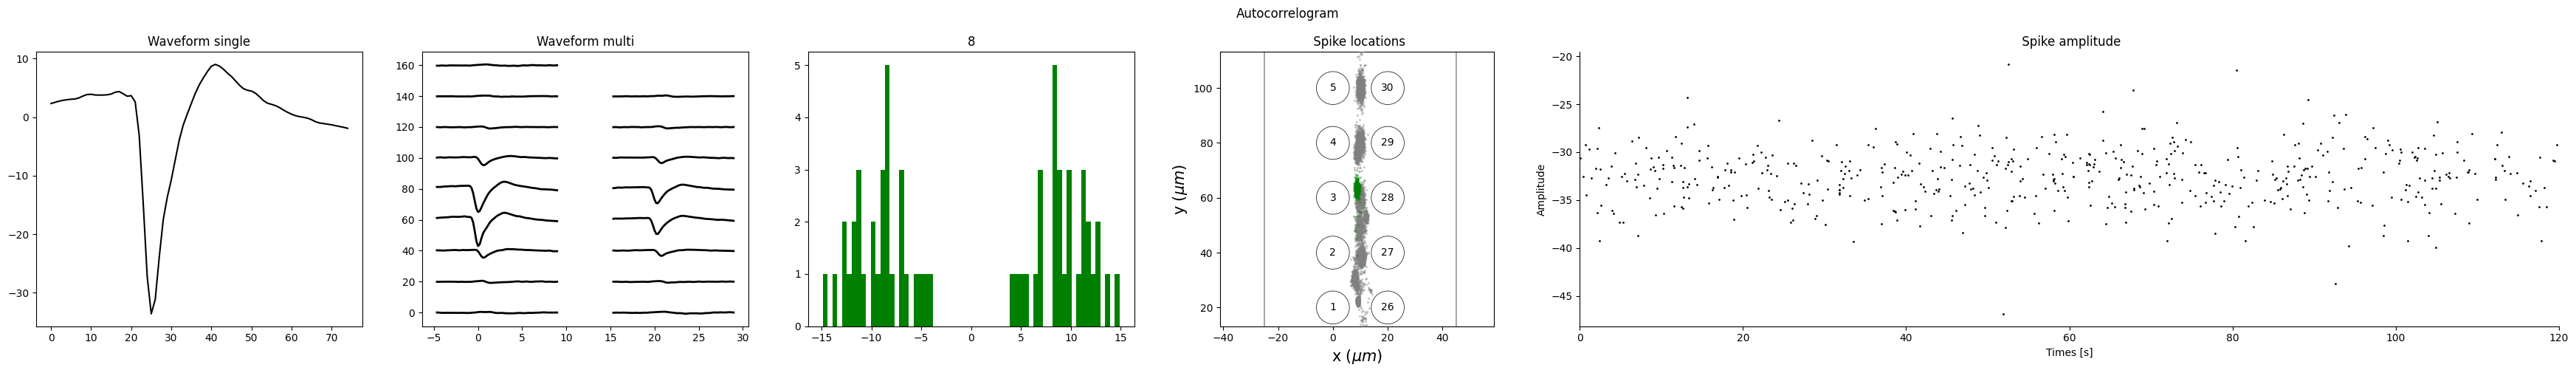

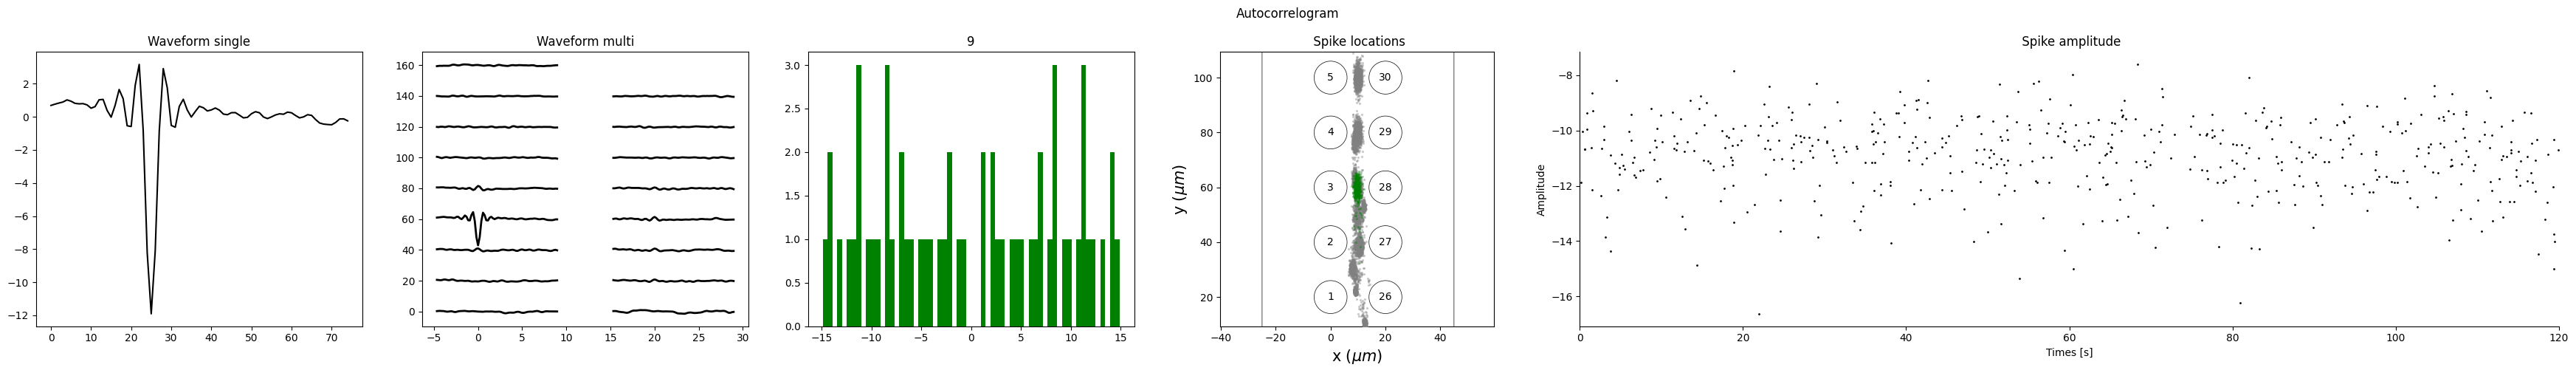

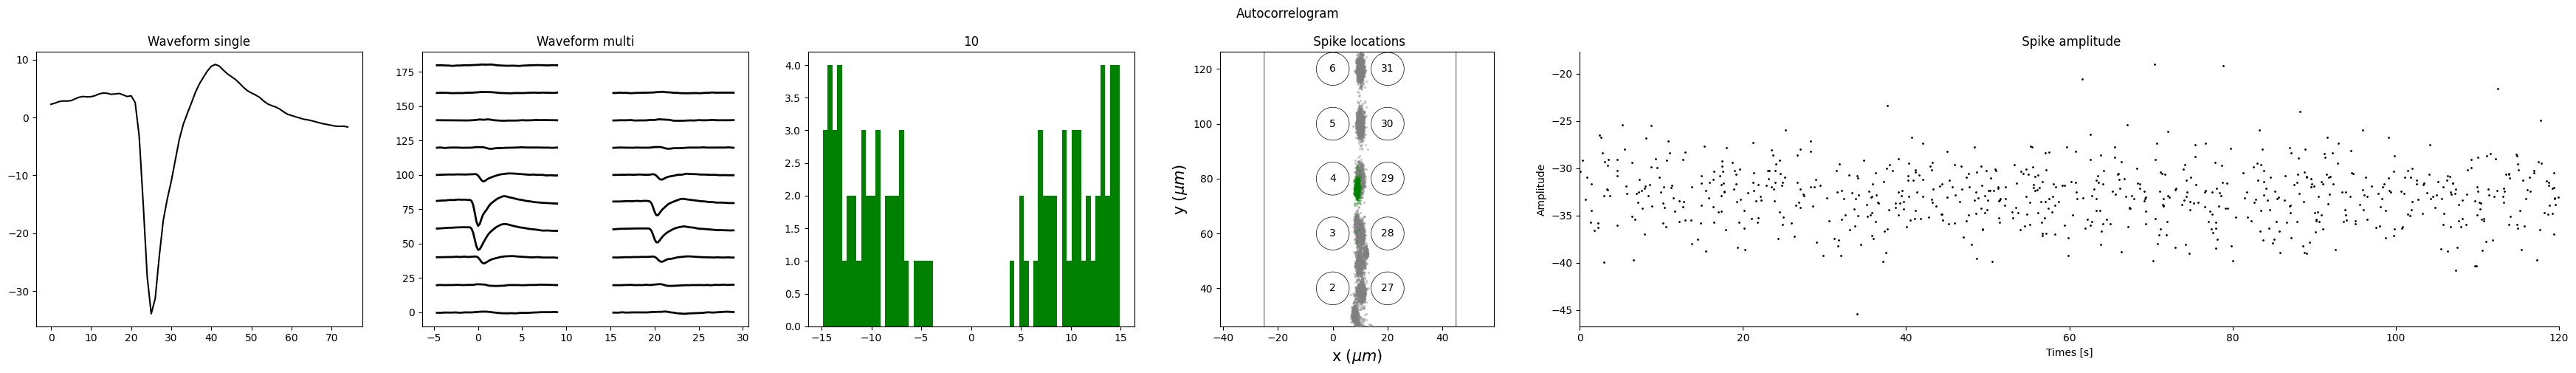

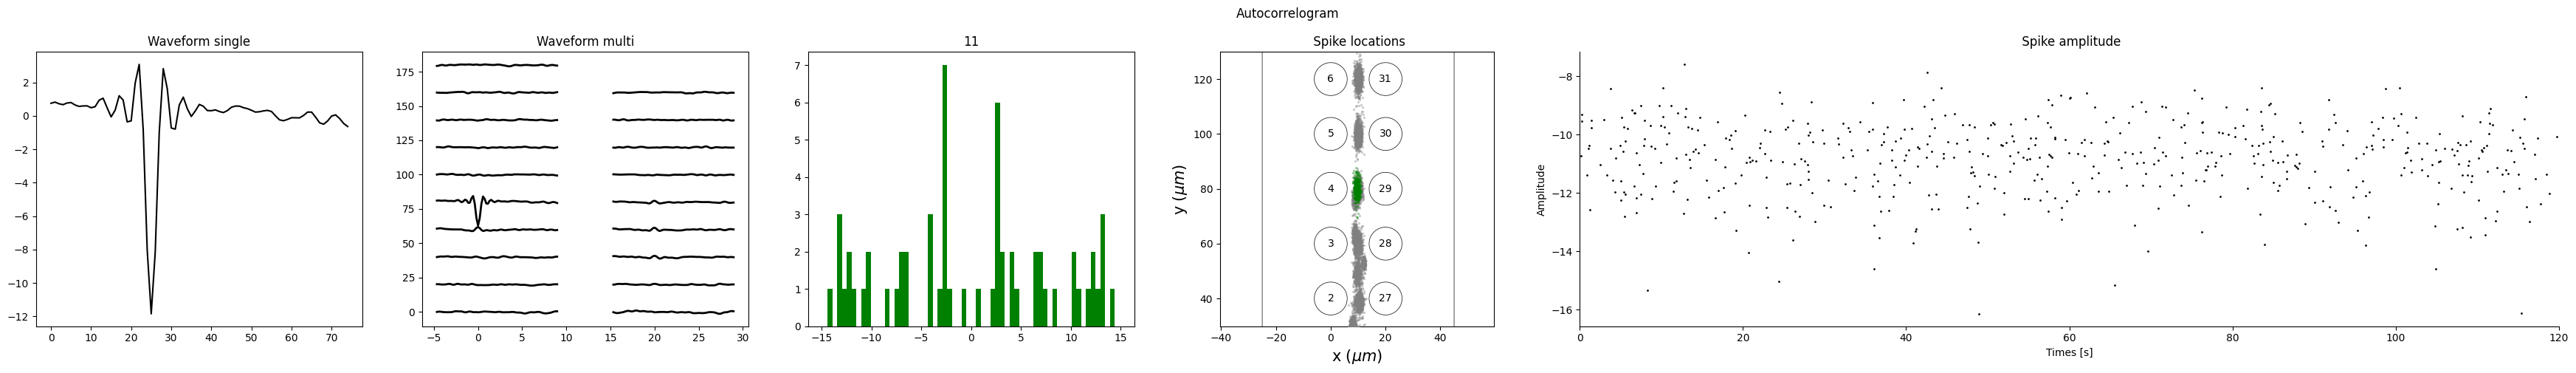

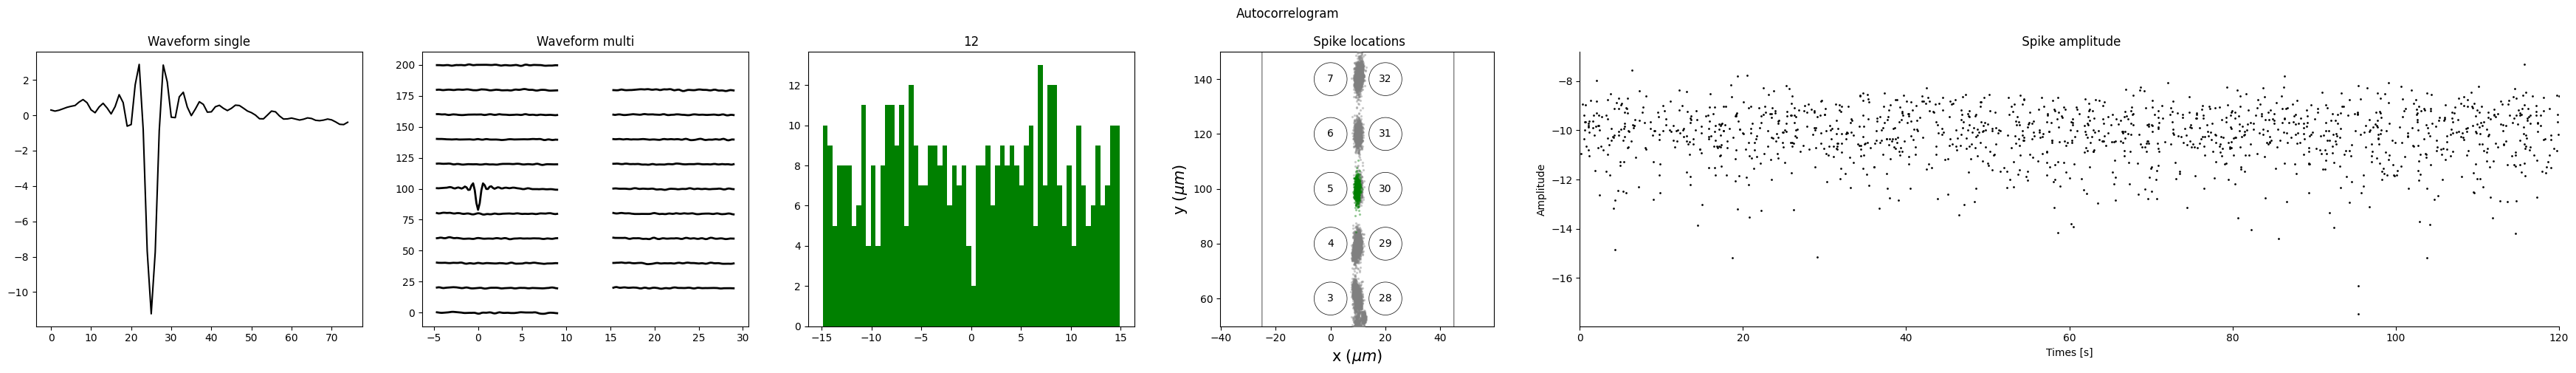

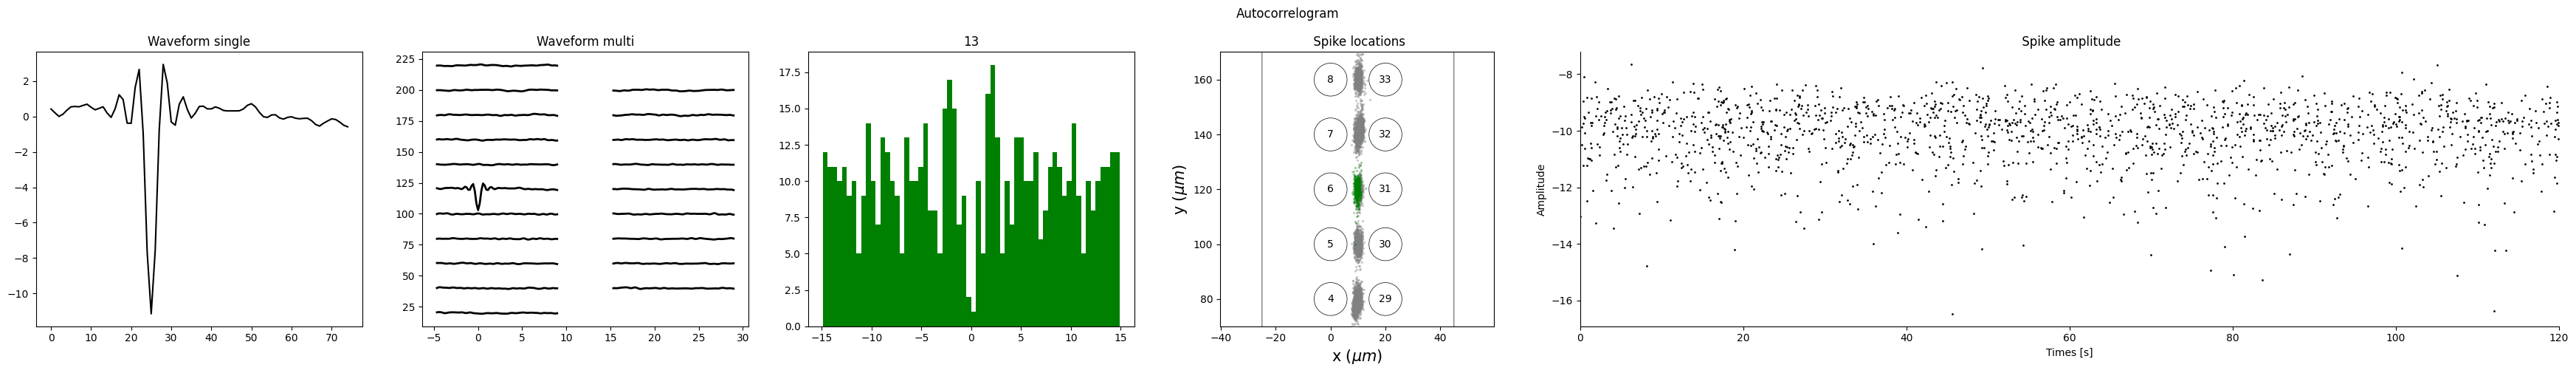

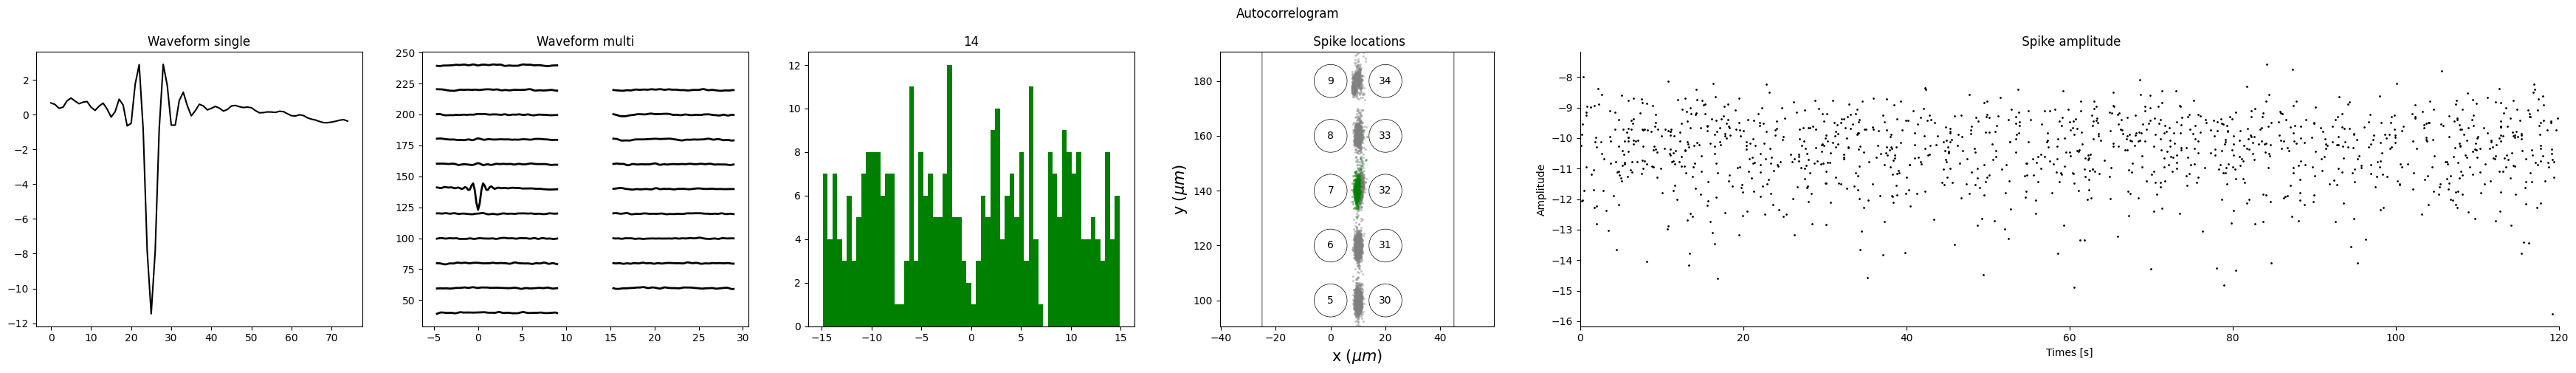

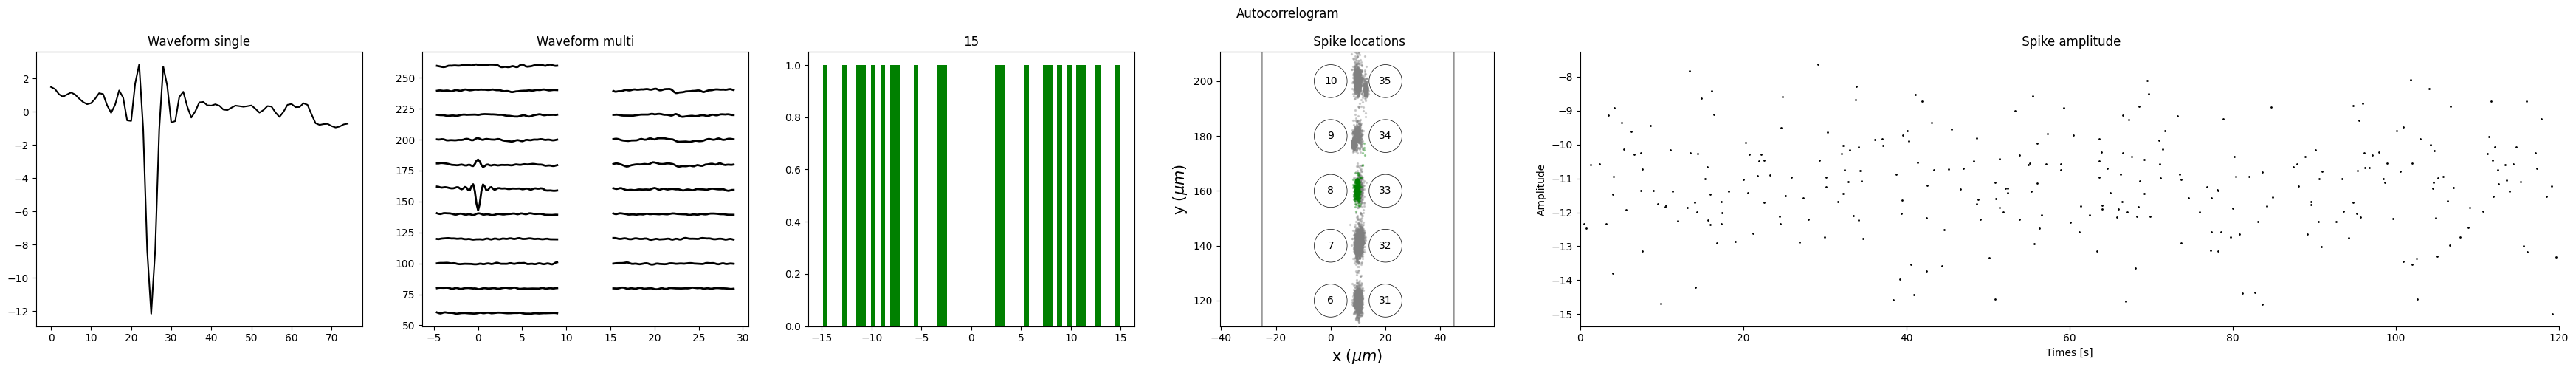

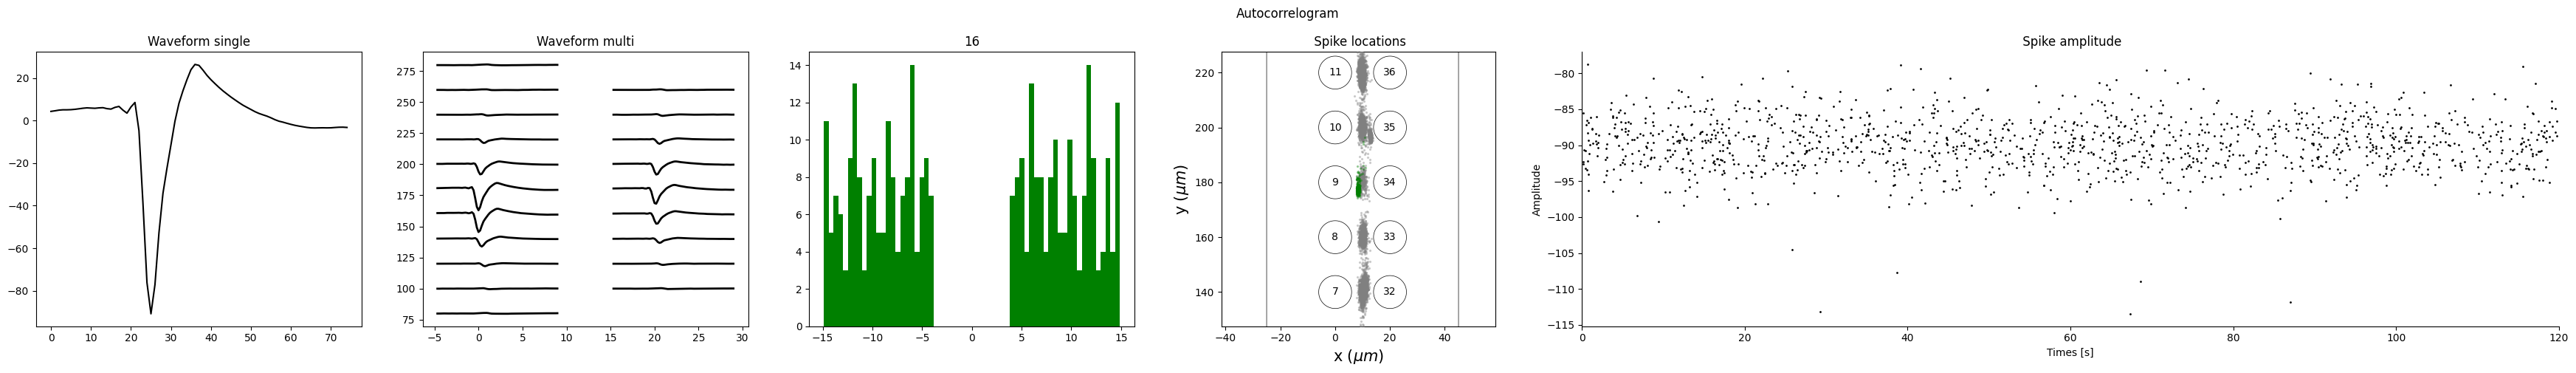

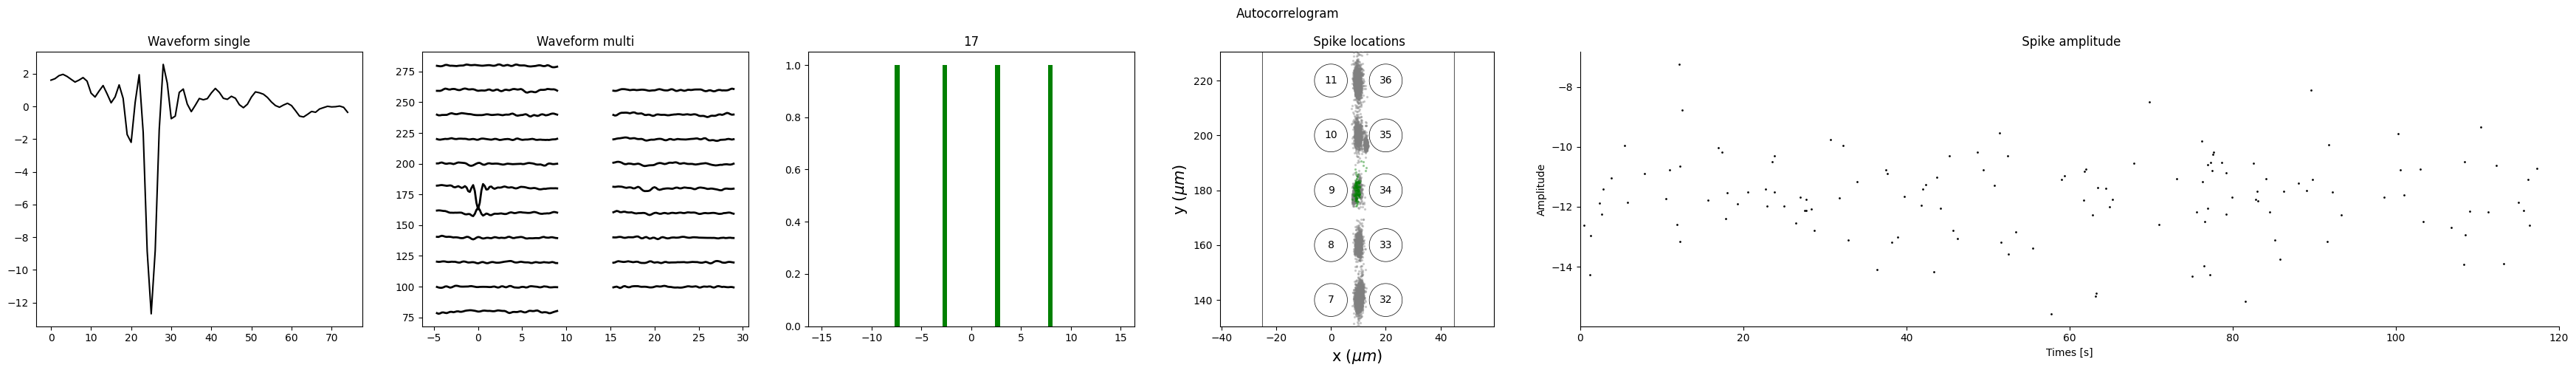

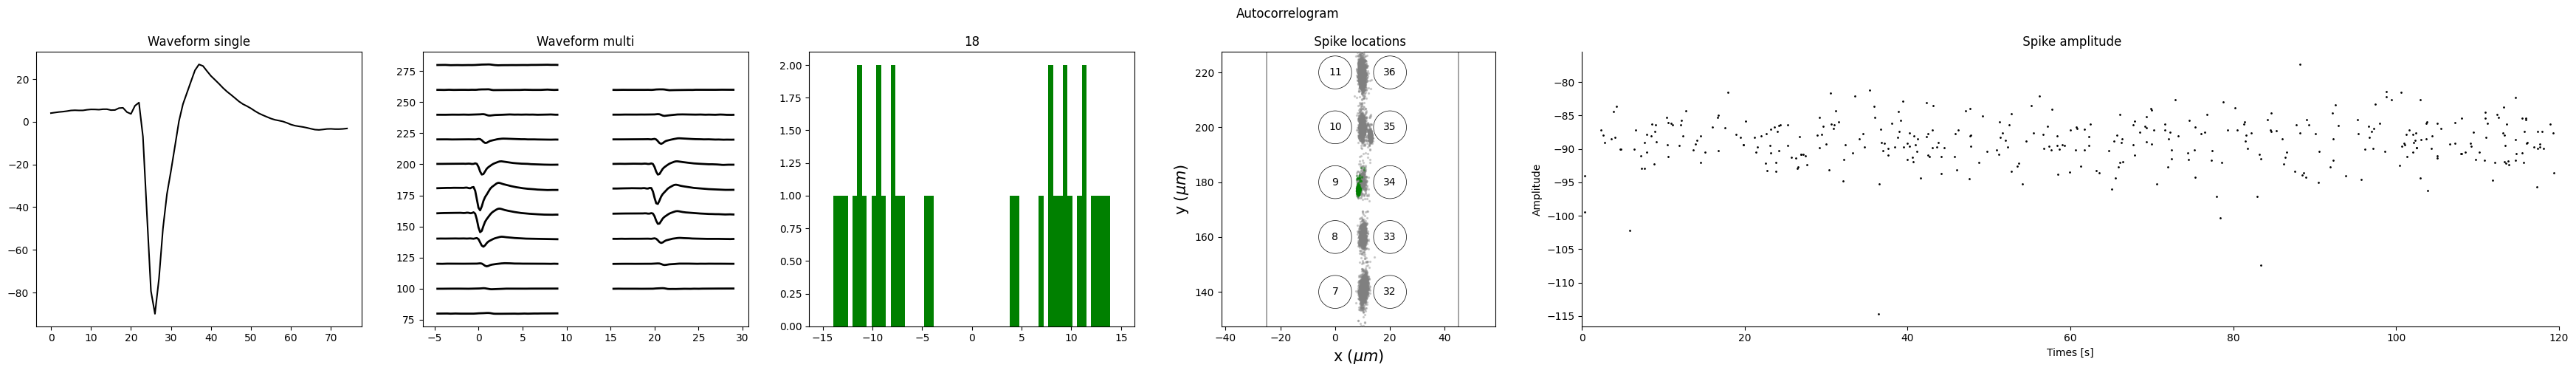

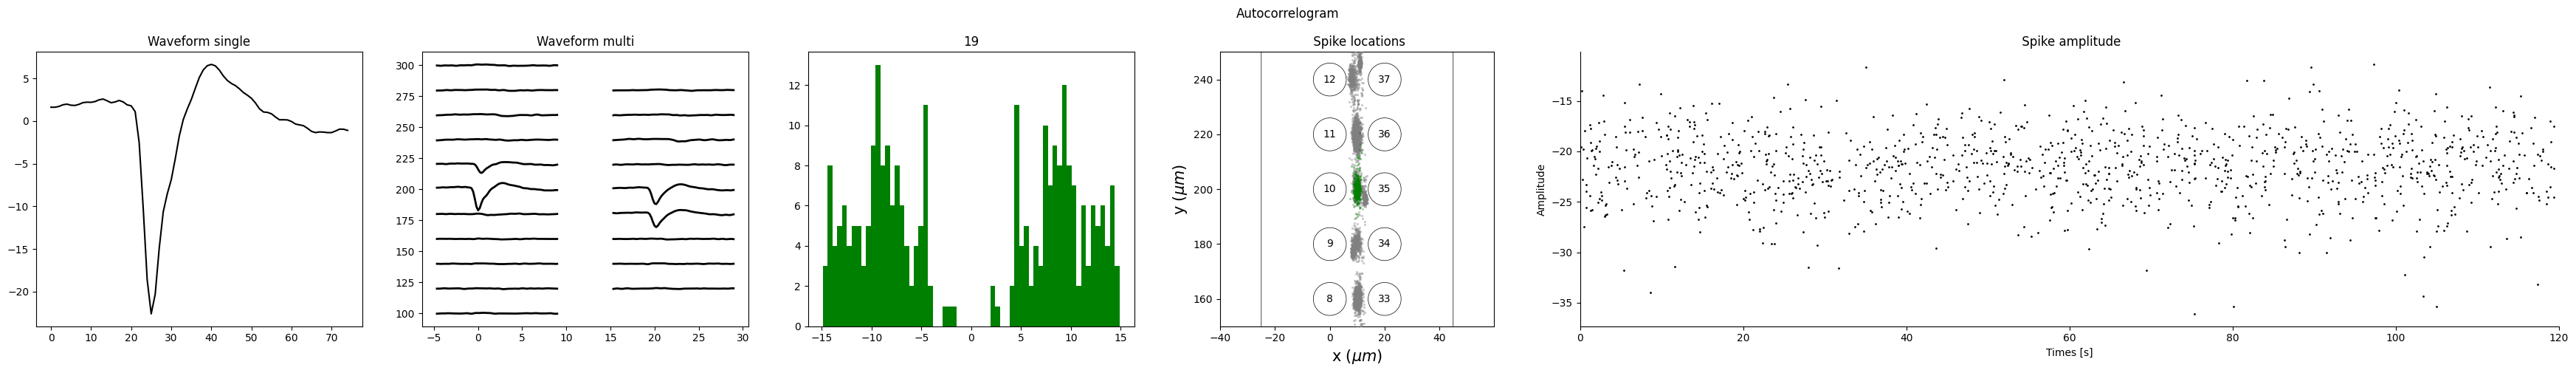

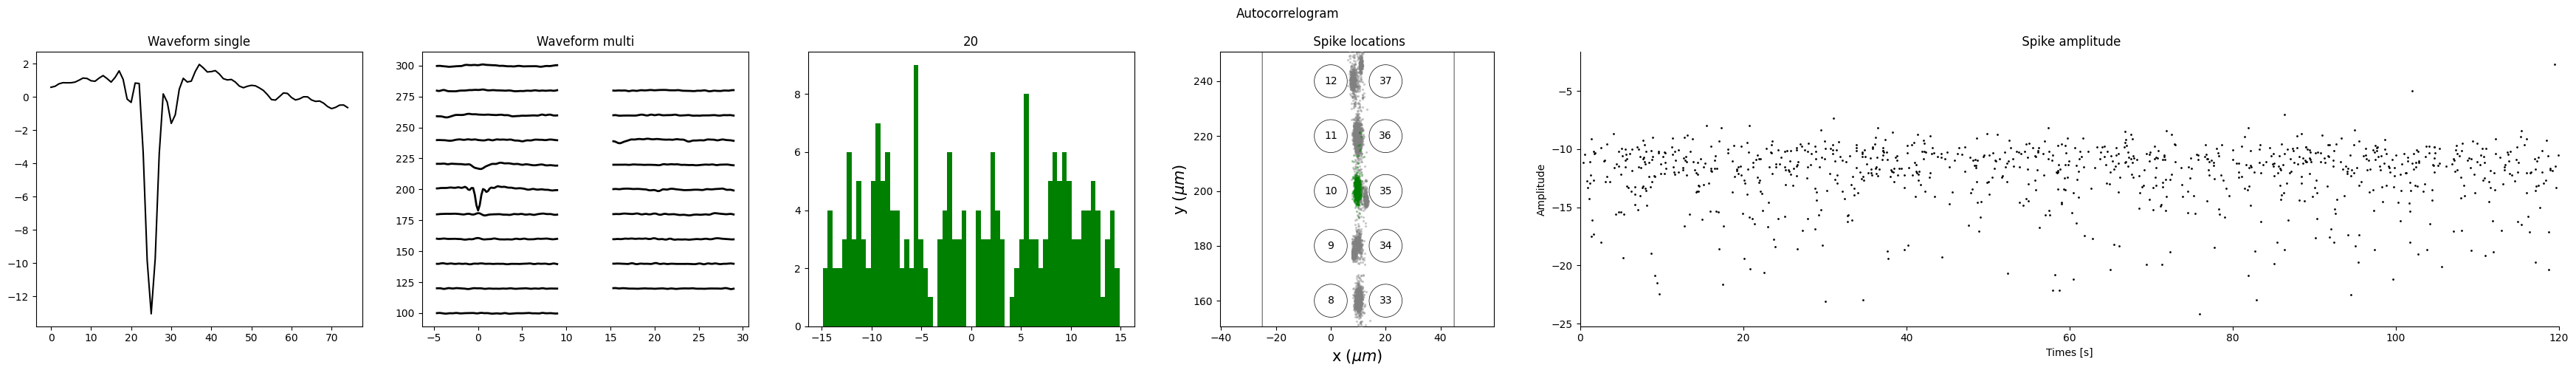

In [18]:
analyzer_to_use = sorting_analyzer
features_to_plot = ['waveform_single', 'waveform_multi', 'autocorr', 'spike_locations', 'amplitude_plot']
sic.plot_units_with_features(
    analyzer_to_use,
    unit_ids=analyzer_to_use.unit_ids[:20],
    features=features_to_plot,
    save=False,
)

---

## 8. VLM Curation

This is the core of our curation pipeline. We use a Vision-Language Model (GPT-4o) to analyze visual representations of each unit and classify them as **Good** or **Bad**.

### Step 8.1: Import VLM Tools and Load API Key

First, import the VLM curation tools and load the OpenAI API key from environment variables.

In [19]:
from tool.vlm_curation import run_vlm_curation, plot_spike_images_with_result
from tool.utils import get_model
from dotenv import load_dotenv
import tool.si_custom as sic
load_dotenv()

True

### Step 8.2: Generate Unit Images

Create a DataFrame containing base64-encoded images for each unit. These images will be sent to the VLM for analysis.

The images include multiple visualization types (features) for comprehensive unit assessment.

In [20]:
unit_img_df = sic.create_unit_img_df(
    sorting_analyzer,
    unit_ids=None,
    load_if_exists=False,
    save_folder=sorting_folder
)

Encoding 86 unit images..


100%|██████████| 86/86 [03:04<00:00,  2.14s/it]


Unit images saved to moutainsort4_sorting/unit_img.csv


### Step 8.3: Run VLM Curation

Now we run the VLM curation. The model will:
1. Analyze each unit's images (waveforms, autocorrelogram, spike locations, amplitudes)
2. Consider quality metrics (SNR, ISI violations, NN hit rate, L-ratio)
3. Use few-shot examples (good_ids and bad_ids) to calibrate its judgments
4. Classify each unit as "Good" or "Bad" with a quality score and reasoning

**Parameters:**
- `model`: The VLM to use (GPT-4o recommended)
- `features`: Which visualizations to analyze
- `good_ids` / `bad_ids`: Example units for few-shot learning
- `with_metrics`: Include quantitative metrics in the analysis
- `metrics_list`: Which metrics to include

⚠️ **Note:** This step uses the OpenAI API and will incur costs. Processing time depends on the number of units.

In [21]:
model = get_model(model_name='gpt-4o')
results_df_fewshot = run_vlm_curation(
    model=model,
    sorting_analyzer=sorting_analyzer,
    img_df=unit_img_df,
    features=["waveform_single", "waveform_multi", "autocorr", "spike_locations", "amplitude_plot"],
    good_ids=[1,4],
    bad_ids=[9,12],
    with_metrics=True,
    metrics_list=["snr","isi_violations_ratio","nn_hit_rate", "l_ratio"]
    )

Processing Units: 100%|██████████| 86/86 [12:17<00:00,  8.58s/unit]


### Step 8.4: Review Curation Results

Let's examine the VLM's classifications. The `results_df` DataFrame contains:
- `average_score`: Mean quality score (0-1) from multiple reviewers
- `final_classification`: "Good" or "Bad" (majority vote)
- `combined_reasoning`: Detailed reasoning from each reviewer

In [22]:
unit_classes = results_df_fewshot.groupby('final_classification').groups
good_units = unit_classes.get('Good', []).tolist()
bad_units = unit_classes.get('Bad', []).tolist()
print('Final VLM Classification Results:')
print(f"Good units: {good_units}\\nBad units: {bad_units}")

Final VLM Classification Results:
Good units: [1, 3, 4, 5, 8, 10, 16, 18, 19, 21, 23, 24, 27, 29, 33, 34, 38, 42, 43, 47, 49, 55, 59, 62, 63, 66, 67, 68, 69, 71, 72, 73, 74, 76, 79, 80, 81, 82, 84, 85]\nBad units: [2, 6, 7, 9, 11, 12, 13, 14, 15, 17, 20, 22, 25, 26, 28, 30, 31, 32, 35, 36, 37, 39, 40, 41, 44, 45, 46, 48, 50, 51, 52, 53, 54, 56, 57, 58, 60, 61, 64, 65, 70, 75, 77, 78, 83, 86]


---

## 9. Apply Curation Results

### Step 9.1: Remove Bad Units

Create a curated analyzer by removing all units classified as "Bad" by the VLM.

In [23]:
analyzer_curated = sorting_analyzer.remove_units(remove_unit_ids=bad_units)

### Step 9.2: Compare with Ground Truth (Post-Curation)

Let's see how the curation improved our results. The agreement matrix should now show cleaner matches with ground truth (fewer false positives).

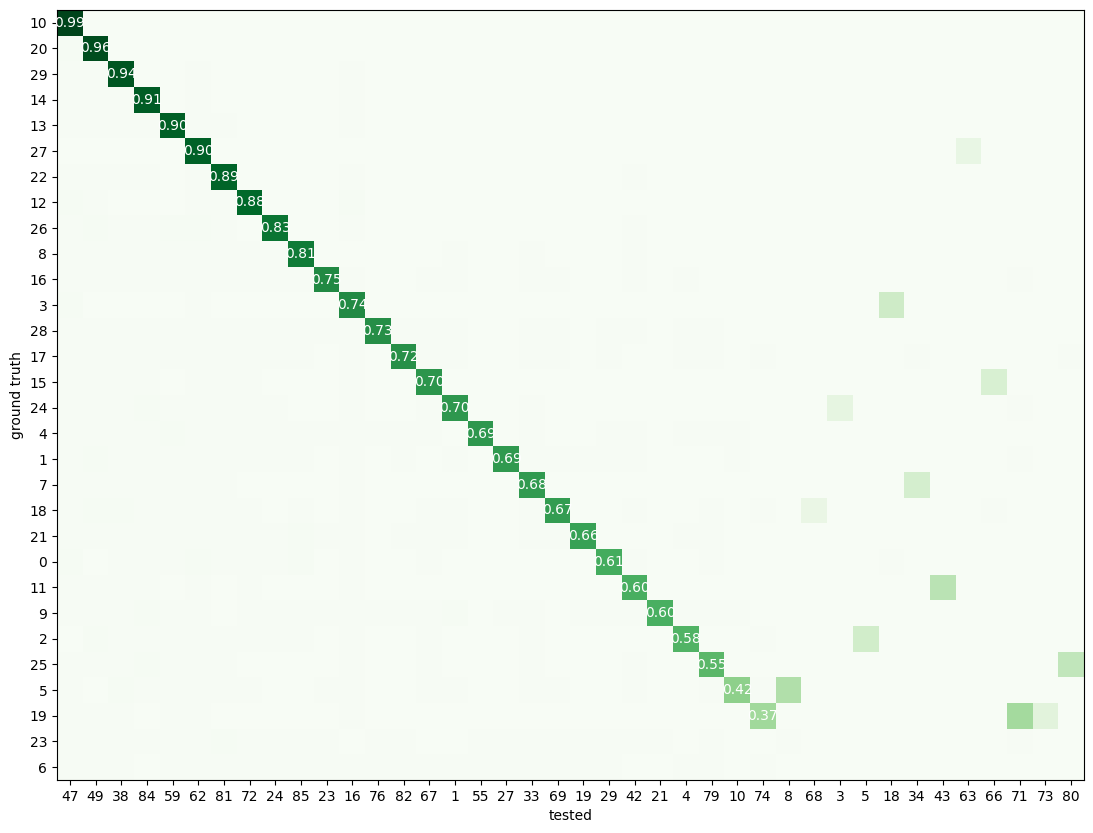

In [24]:
comp_gt_curated = si.compare_sorter_to_ground_truth(gt_sorting=gt_sorting0, tested_sorting=analyzer_curated.sorting, exhaustive_gt=True)
si.plot_agreement_matrix(comp_gt_curated, figsize=(20, 10))

### Step 9.3: Examine Individual Results

You can inspect the full `results_df` and view the detailed reasoning for specific units.

In [35]:
results_df

average_score final_classification  \
unit_ids                                       
1                  1.00                 Good   
2                  0.13                  Bad   
3                  0.83                 Good   
4                  0.95                 Good   
5                  0.87                 Good   
...                 ...                  ...   
82                 0.97                 Good   
83                 0.20                  Bad   
84                 0.98                 Good   
85                 0.92                 Good   
86                 0.20                  Bad   

                                         combined_reasoning  reviewer_1_score  \
unit_ids                                                                        
1         Reviewer 1: The waveform is described as havin...              1.00   
2         Reviewer 1: The waveform is clearly problemati...              0.10   
3         Reviewer 1: The waveform is described as high-...              0.85   
4         Reviewer 1: The waveform is described as havin...              0.95   
5         Reviewer 1: The waveform is described as high-...              0.85   
...                                                     ...               ...   
82        Reviewer 1: The waveform is described as high-...              0.95   
83        Reviewer 1: The waveform is clearly bad, with ...              0.20   
84        Reviewer 1: The waveform is described as havin...              1.00   
85        Reviewer 1: The waveform is described as havin...              0.95   
86        Reviewer 1: The waveform analysis indicates a ...              0.20   

          reviewer_2_score  reviewer_3_score reviewer_1_class  \
unit_ids                                                        
1                     1.00              1.00             Good   
2                     0.10              0.20              Bad   
3                     0.80              0.85             Good   
4                     0.95              0.95             Good   
5                     0.85              0.90             Good   
...                    ...               ...              ...   
82                    1.00              0.95             Good   
83                    0.20              0.20              Bad   
84                    0.95              1.00             Good   
85                    0.85              0.95             Good   
86                    0.20              0.20              Bad   

         reviewer_2_class reviewer_3_class  
unit_ids                                    
1                    Good             Good  
2                     Bad              Bad  
3                    Good             Good  
4                    Good             Good  
5                    Good             Good  
...                   ...              ...  
82                   Good             Good  
83                    Bad              Bad  
84                   Good             Good  
85                   Good             Good  
86                    Bad              Bad  

[86 rows x 9 columns]

### Step 9.4: Visualize a Curated Unit

Examine features of a curated unit to confirm quality.

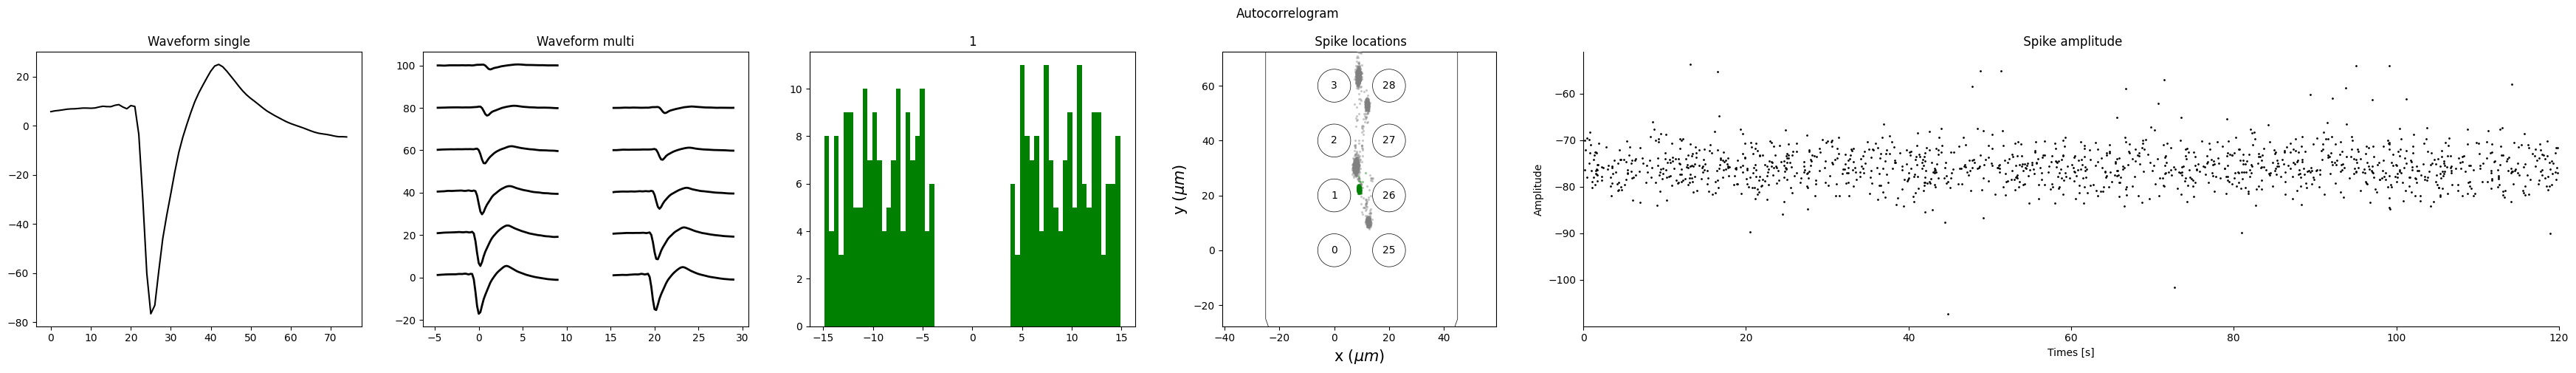

In [39]:
sic.plot_units_with_features(
    analyzer_curated,
    unit_ids=analyzer_curated.unit_ids[0:1],
    features=features_to_plot,
    save=False,
)

### Step 9.5: View Detailed Reasoning

Inspect the VLM's reasoning for a specific unit to understand why it was classified as Good or Bad.

In [36]:
# For a specific unit ID
unit_id = 1  # change to your unit ID
print(results_df.loc[unit_id, 'combined_reasoning'])

Reviewer 1: The waveform is described as having a stable pre-spike baseline, a well-defined negative peak, and a smooth return to baseline, indicating a high-quality waveform. The spatial distribution of the spike across channels shows a clear main spike with aligned smaller spikes on adjacent channels, suggesting good spatial continuity. The autocorrelogram shows a clear dip around 0 ms, indicating a refractory period and suggesting a well-isolated neuron. The spike location plot shows a compact and well-isolated cluster, and the amplitude stability plot indicates consistent spike amplitudes over time. Additionally, the quantitative metrics are excellent, with a high SNR, zero ISI violations, a high NN hit rate, and a perfect L-ratio, all indicating a well-isolated unit. Overall, all modalities support the conclusion that this unit is a well-isolated single neuron.
Reviewer 2: The waveform is described as having a stable pre-spike baseline, a well-defined negative peak, and a smooth r

### Step 9.6: Visualize Classification Results

Plot all units grouped by their classification (Good vs Bad) with their quality scores.

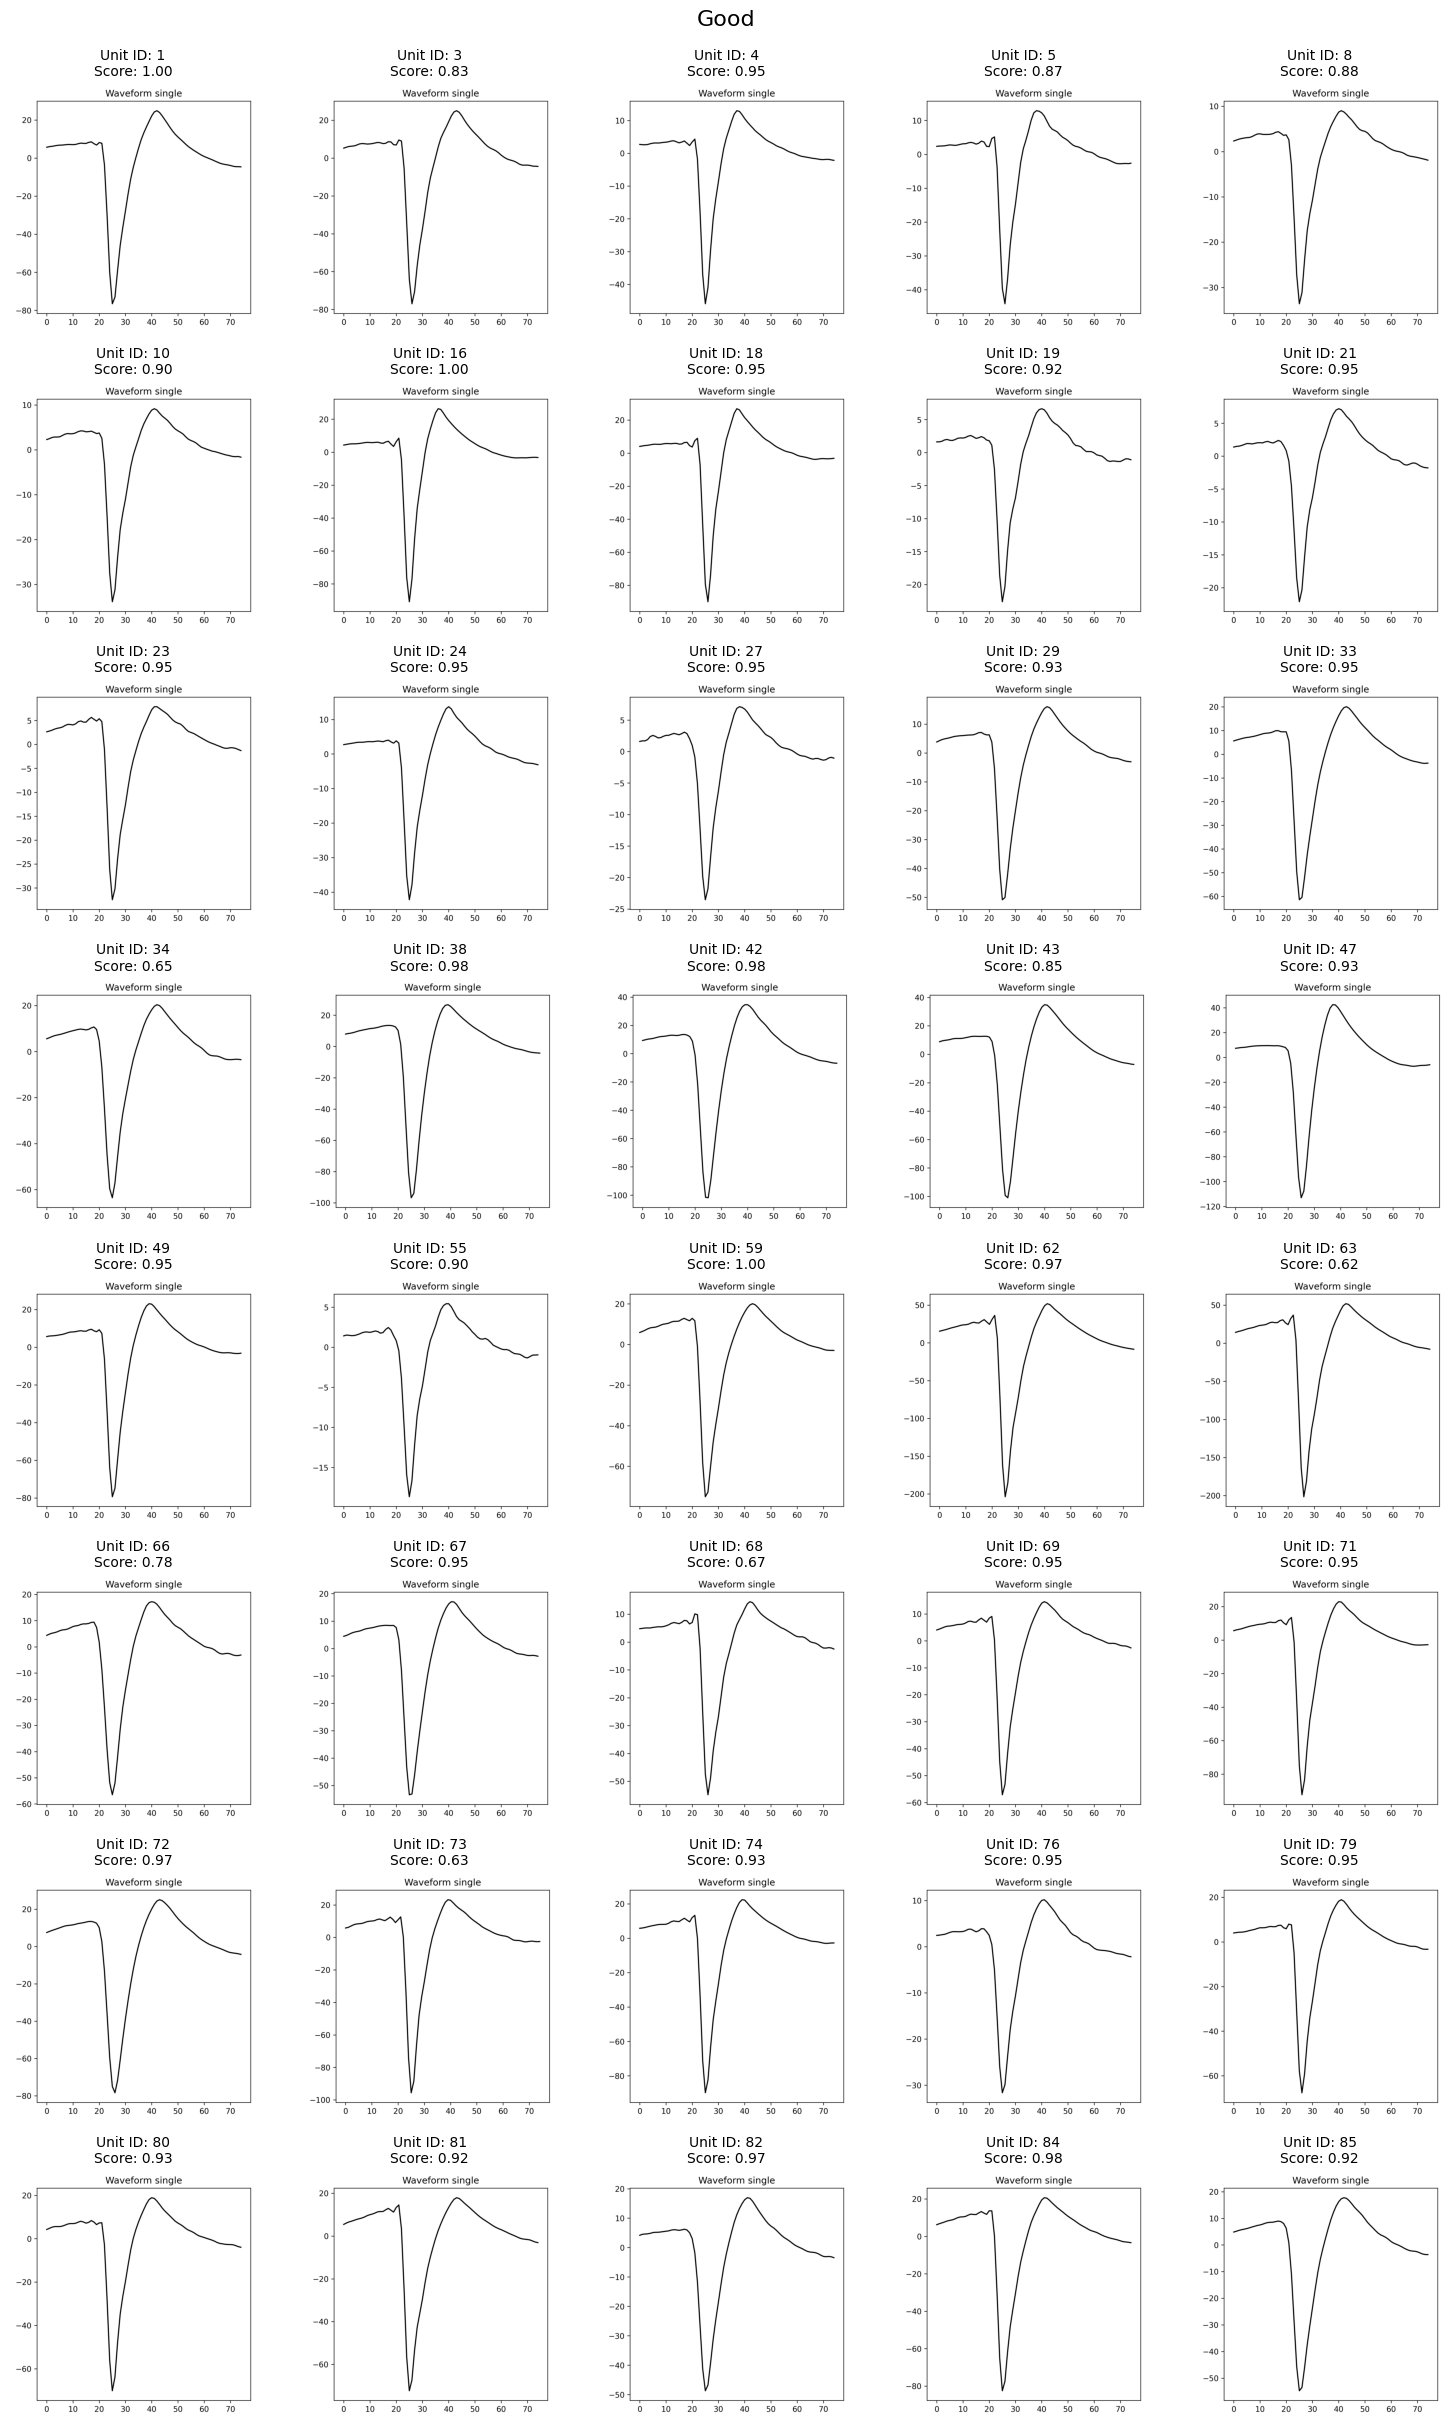

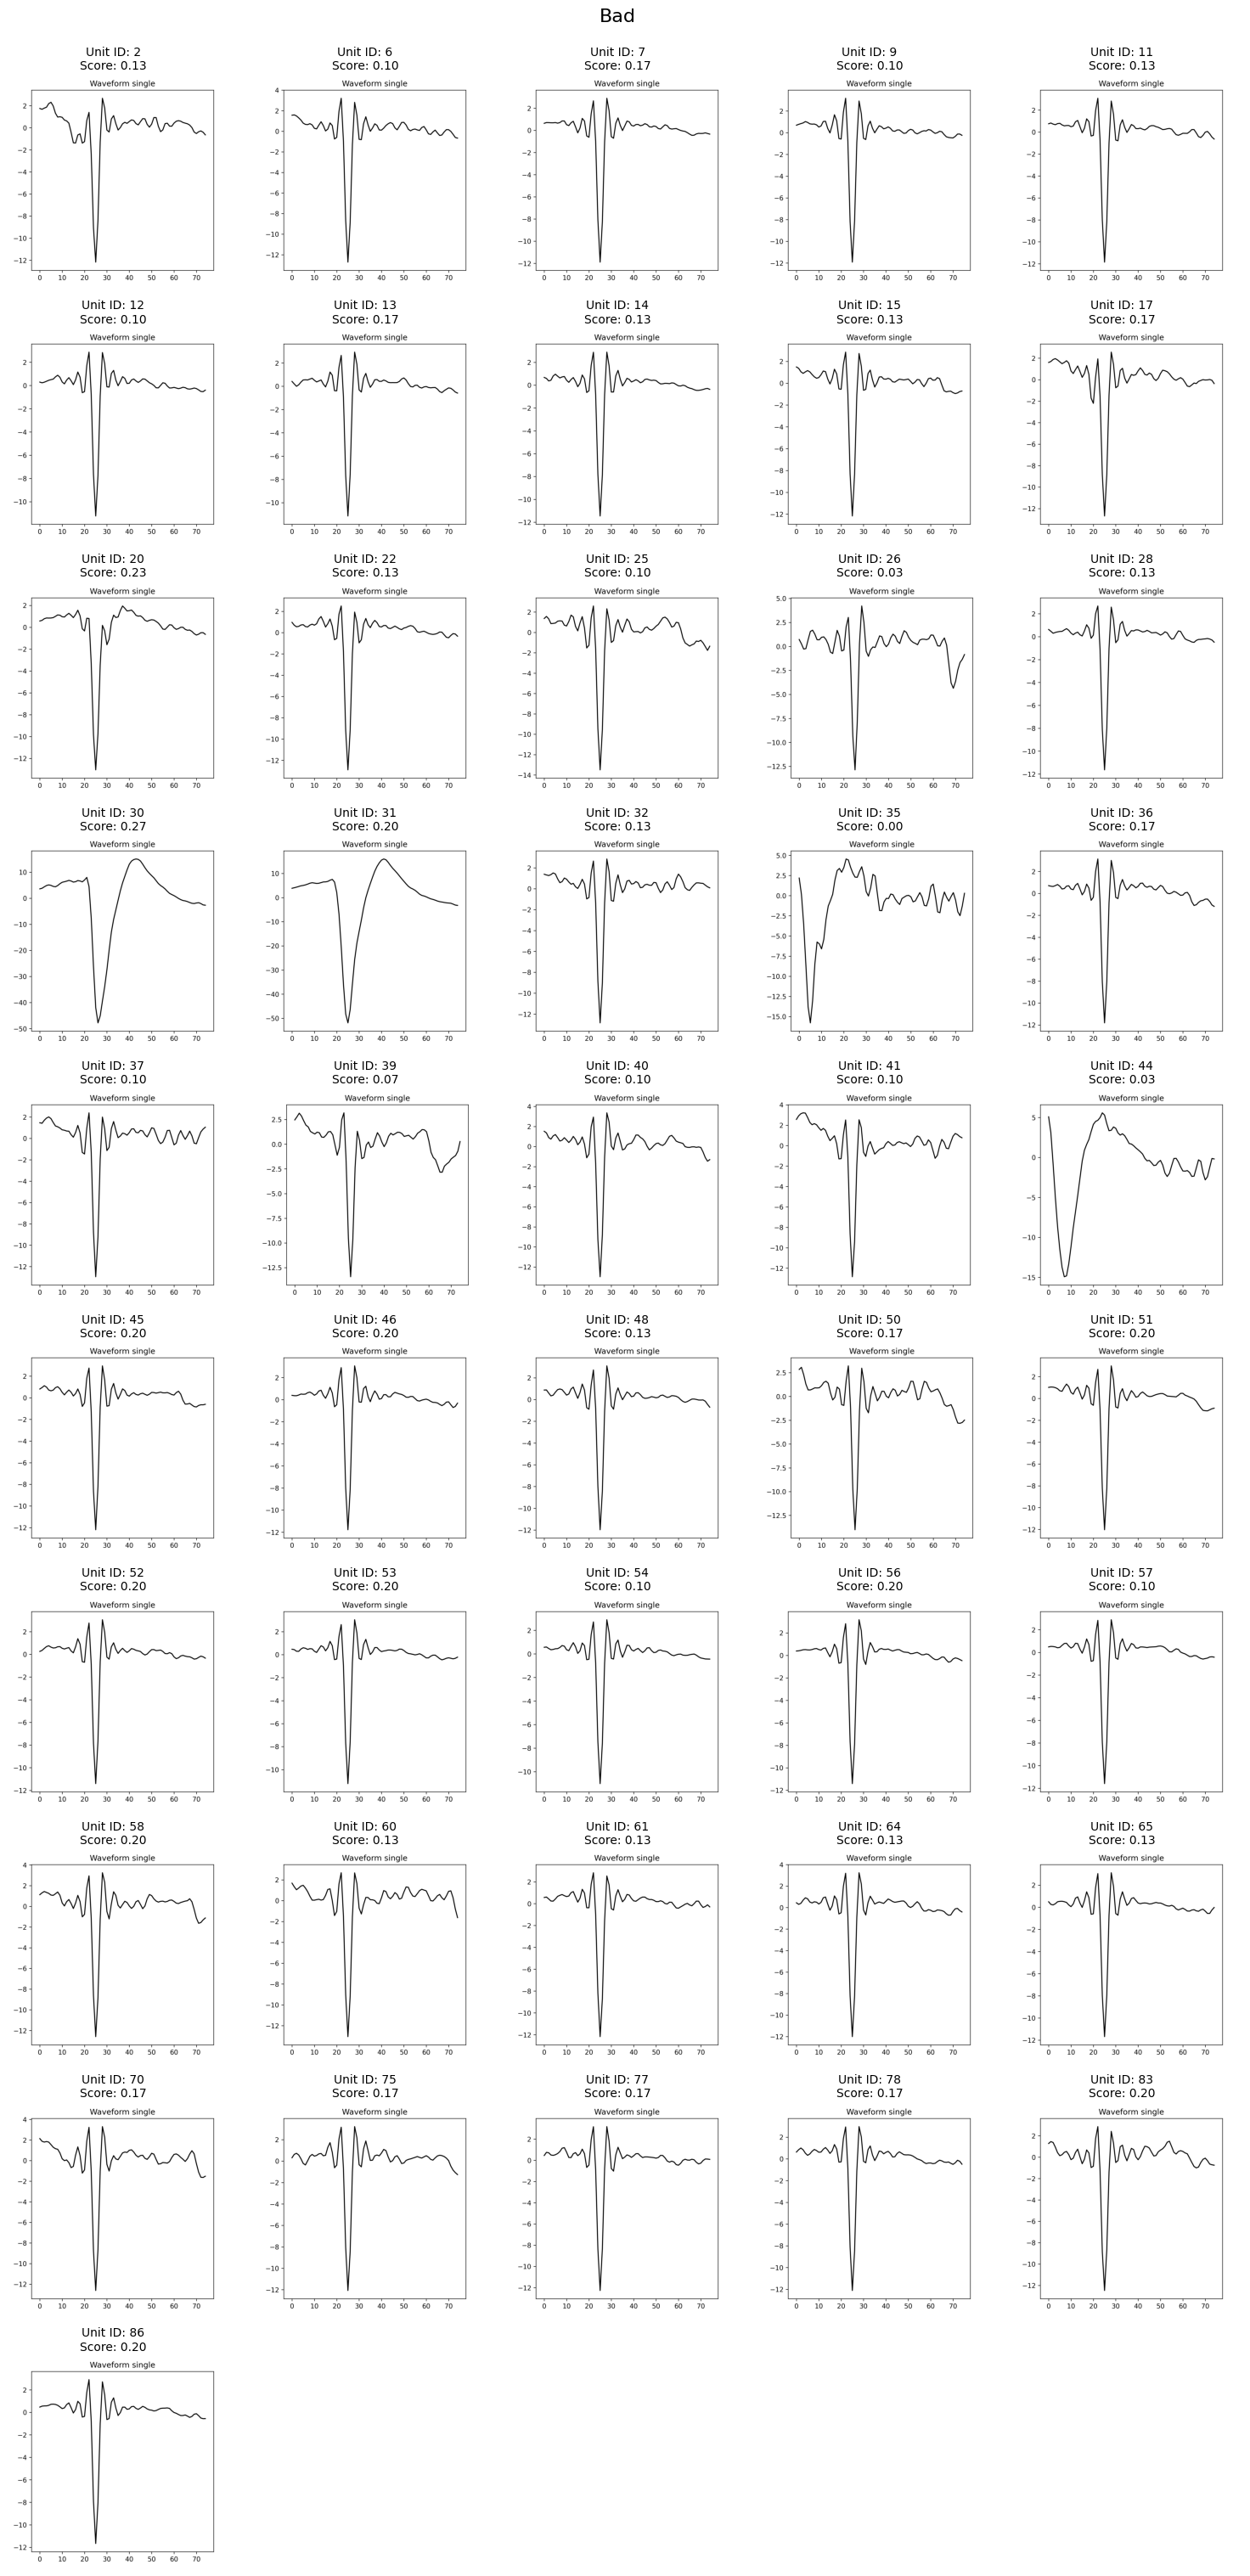

In [29]:
plot_spike_images_with_result(results_df, unit_img_df, feature="waveform_single")

---

## 10. VLM Merge Analysis

After curation, we may still have **duplicate units** - the same neuron detected multiple times. The VLM merge module identifies and merges these duplicates.

### Step 10.1: Find Potential Merge Candidates

Use template similarity to identify pairs of units that might be the same neuron. Units with similar waveform templates are potential merge candidates.

In [25]:
from spikeinterface.curation import compute_merge_unit_groups
analyzer_to_merge = analyzer_curated
template_diff_thresh = 0.2
print("--- Step 1: Computing potential merge candidates ---")
steps = ["template_similarity"]
steps_params = {
    "template_similarity": {"template_diff_thresh": template_diff_thresh}
}
potential_merge_groups_clean = compute_merge_unit_groups(
    analyzer_to_merge,
    resolve_graph=False,
    steps_params=steps_params,
    steps=steps
)
num_groups = len(potential_merge_groups_clean)
print(f"Found {num_groups} potential merge groups.")
if num_groups > 15:
    print("Showing only the first 15 groups:")
for i, group in enumerate(potential_merge_groups_clean[:15]):
    print(f"  Group {i}: {group}")

--- Step 1: Computing potential merge candidates ---
Found 26 potential merge groups.
Showing only the first 15 groups:
  Group 0: (1, 3)
  Group 1: (1, 4)
  Group 2: (1, 5)
  Group 3: (3, 4)
  Group 4: (3, 5)
  Group 5: (4, 5)
  Group 6: (8, 10)
  Group 7: (16, 18)
  Group 8: (29, 69)
  Group 9: (33, 34)
  Group 10: (42, 43)
  Group 11: (42, 82)
  Group 12: (43, 82)
  Group 13: (62, 63)
  Group 14: (66, 67)


### Step 10.2: Generate Merge Images

Create visualizations for each merge candidate pair. These include:
- **Cross-correlograms**: Should show a refractory period dip if from the same neuron
- **Amplitude plots**: Overlaid amplitude traces for comparison
- **Waveforms**: Side-by-side waveform comparison

In [40]:
merge_img_df = sic.create_merge_img_df(analyzer_curated, unit_groups=potential_merge_groups_clean, load_if_exists=False, save_folder=sorting_folder)

  0%|          | 0/26 [00:00<?, ?it/s]/media/data0/spikeagent/revision/spikeagent_0.102.3_zuwan_test/tool/si_custom/custom_plot.py:468: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(scores[:, 0], scores[:, 1],
  4%|▍         | 1/26 [00:01<00:38,  1.54s/it]/media/data0/spikeagent/revision/spikeagent_0.102.3_zuwan_test/tool/si_custom/custom_plot.py:468: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(scor

Merge images saved to moutainsort4_sorting/merge_img.csv


### Step 10.3: Run VLM Merge Analysis

The VLM analyzes each merge candidate pair and decides whether to merge based on:
1. **Cross-correlogram**: A dip around 0ms (refractory period) suggests same neuron
2. **Amplitude overlap**: Similar amplitude distributions suggest same source
3. **Waveform similarity**: Morphologically similar waveforms support merging

**Critical decision rule**: If the cross-correlogram shows spikes in the refractory period (around 0ms), the units are likely from different neurons and should NOT be merged.

In [41]:
import os
import tool.si_custom as sic
from tool.vlm_merge import run_vlm_merge, plot_merge_results
from tool.utils import get_model
model = get_model(model_name="gpt-4o")
merge_results_df_fewshot = run_vlm_merge(
    model=model,
    merge_unit_groups=potential_merge_groups_clean,
    img_df=merge_img_df,
    features=["crosscorrelograms", "amplitude_plot", "waveform_single"],
    num_workers=50
)

Processing Groups: 100%|██████████| 26/26 [01:56<00:00,  4.46s/unit]


### Step 10.4: Visualize Merge Results

Display all merge candidate pairs with their VLM decisions.

/media/data0/spikeagent/revision/spikeagent_0.102.3_zuwan_test/tool/vlm_merge/process_img.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(15, 4))


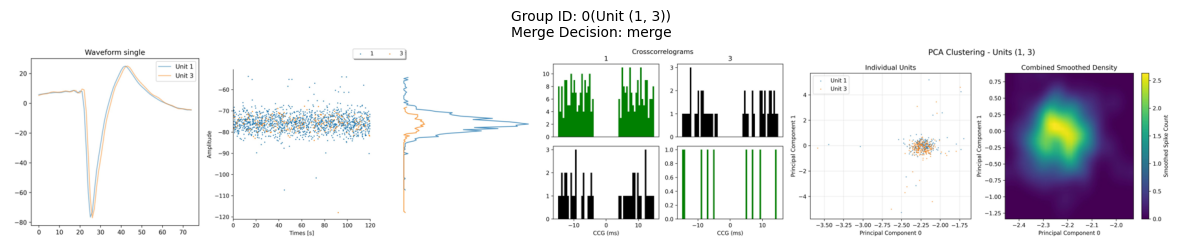

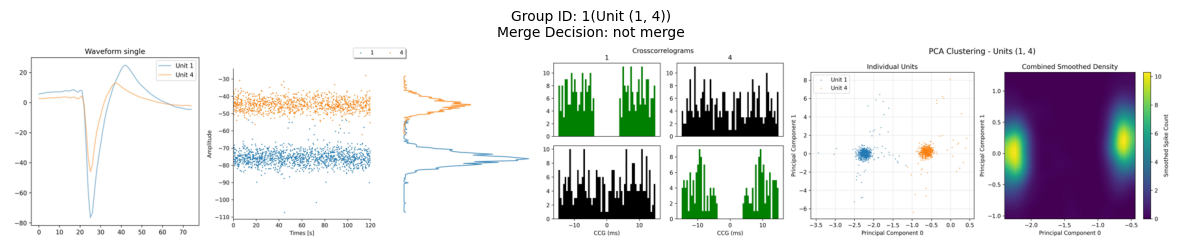

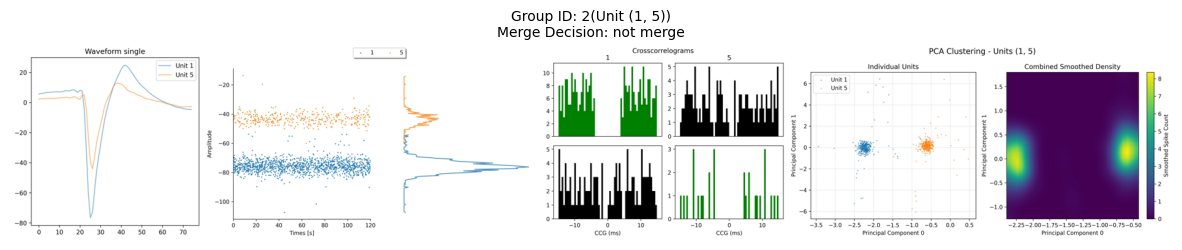

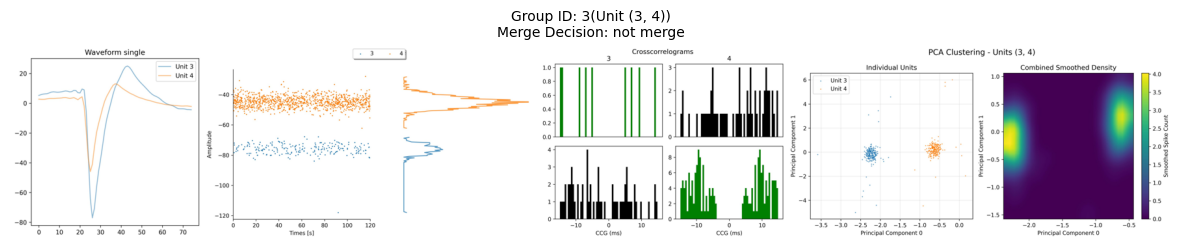

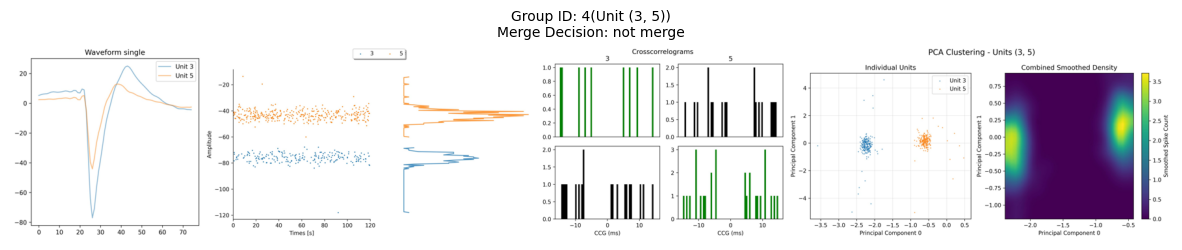

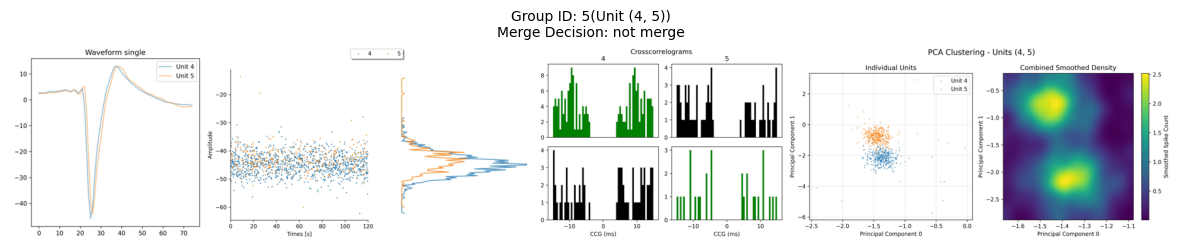

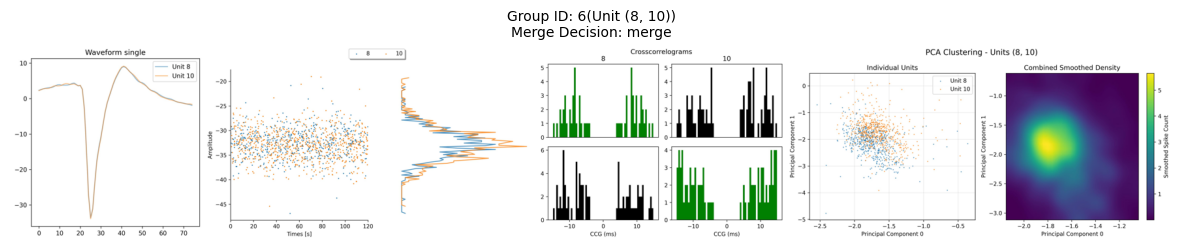

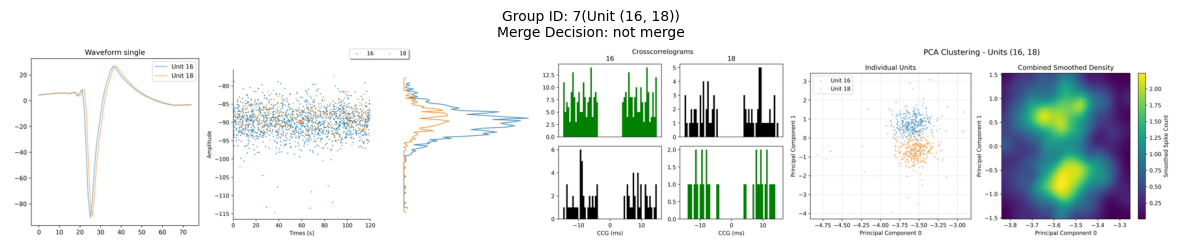

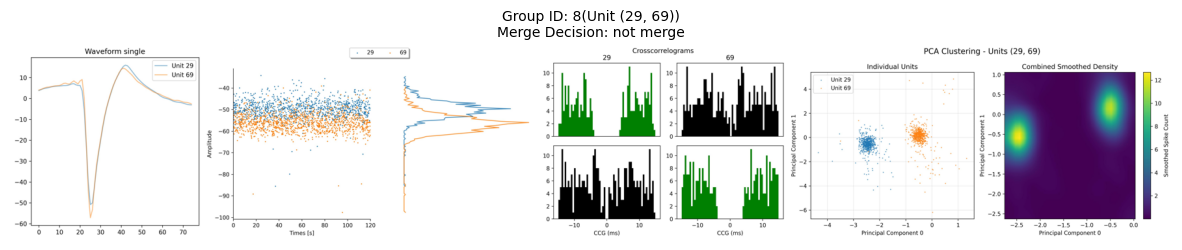

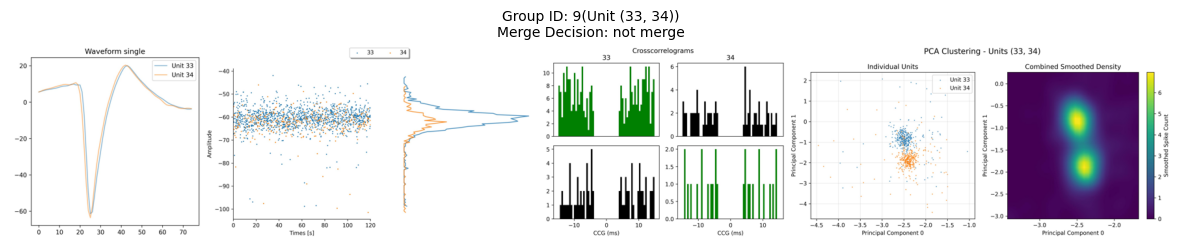

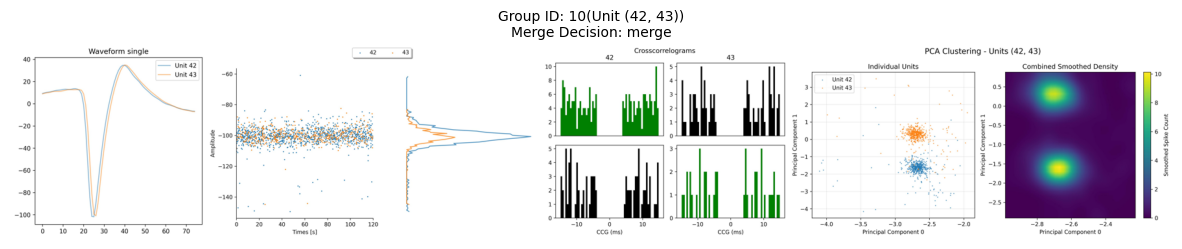

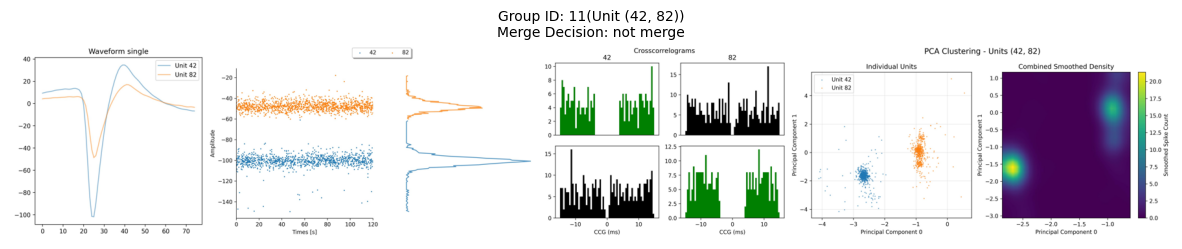

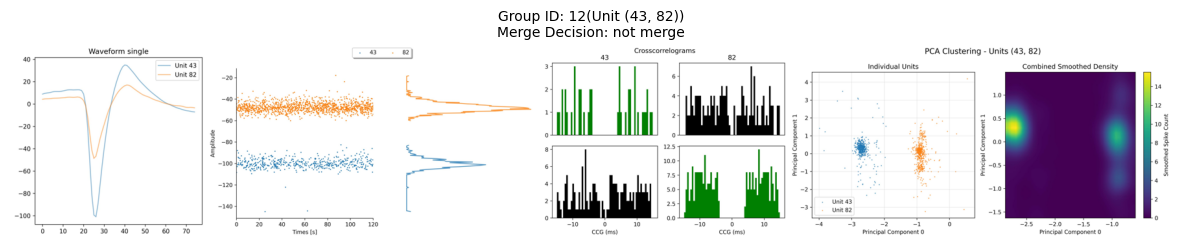

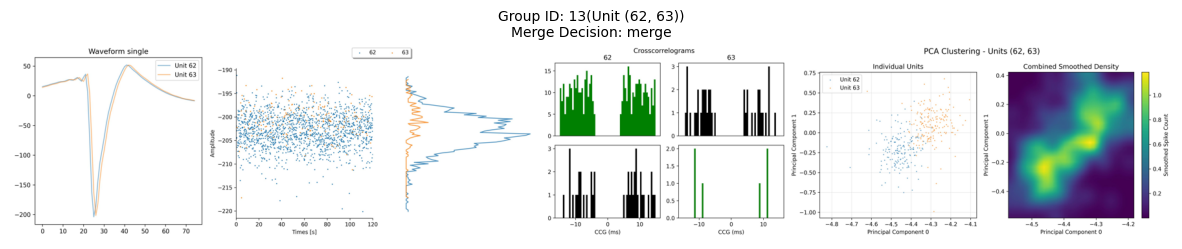

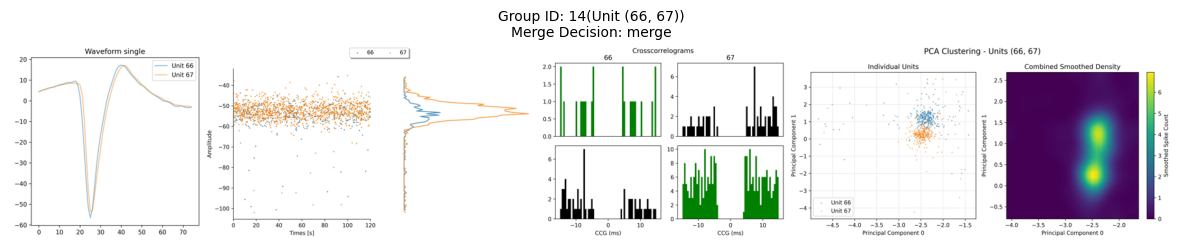

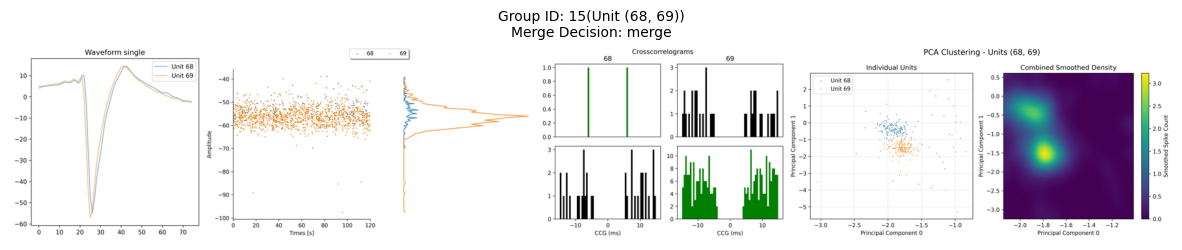

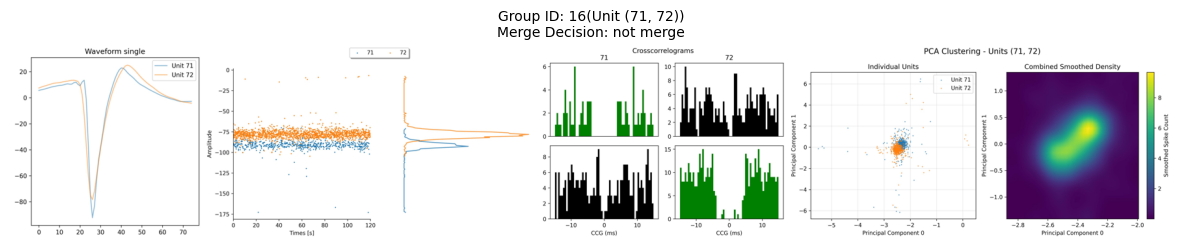

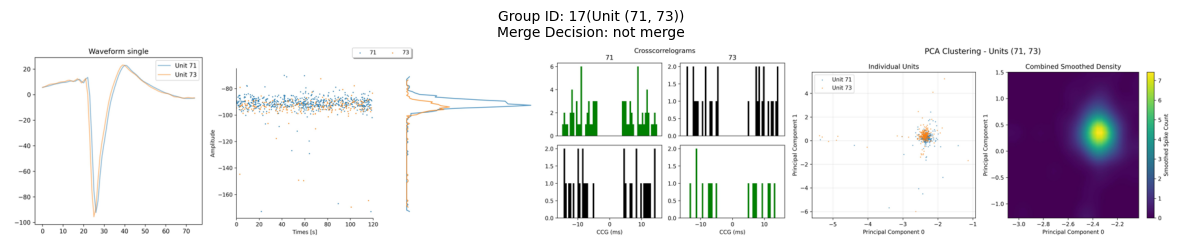

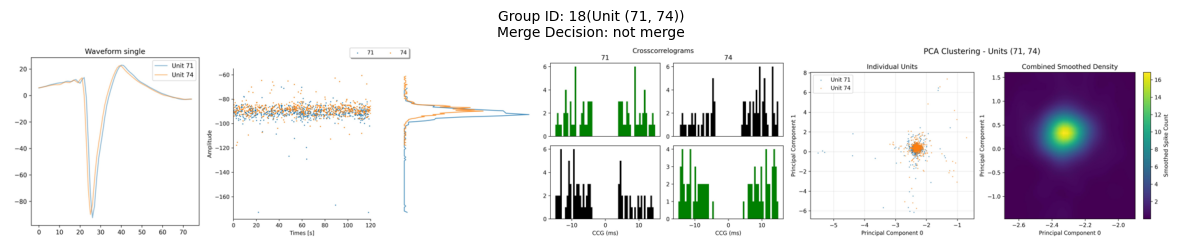

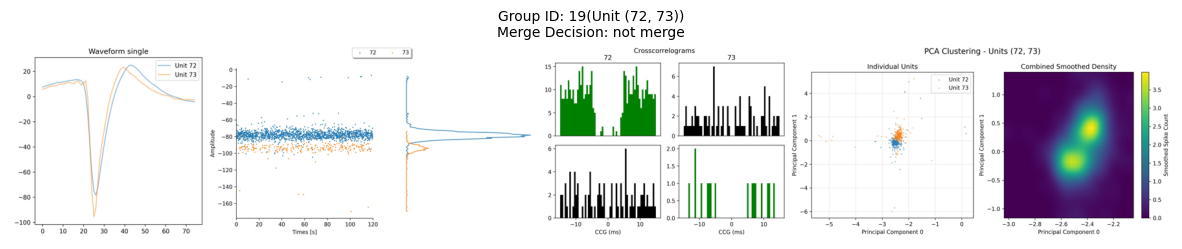

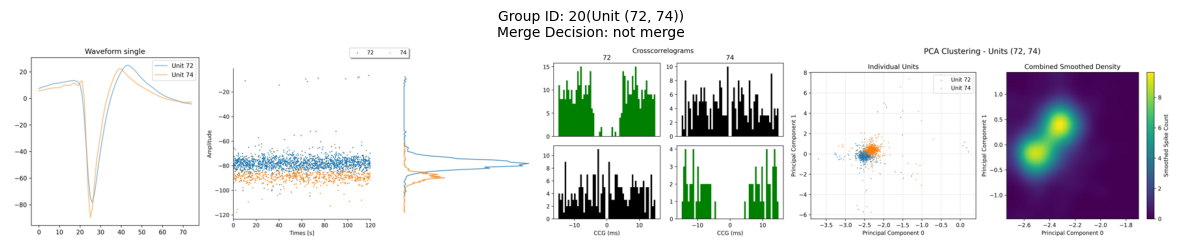

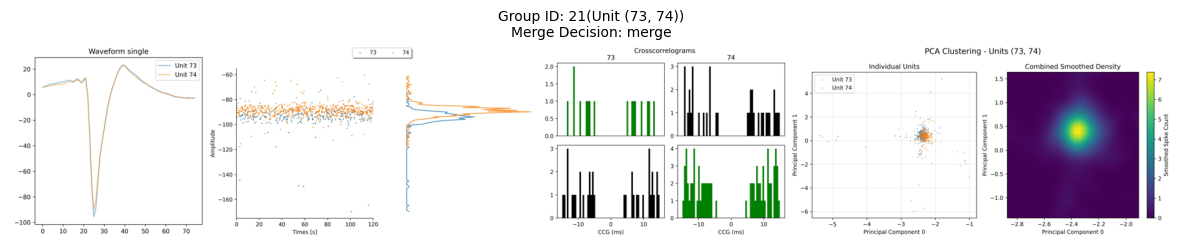

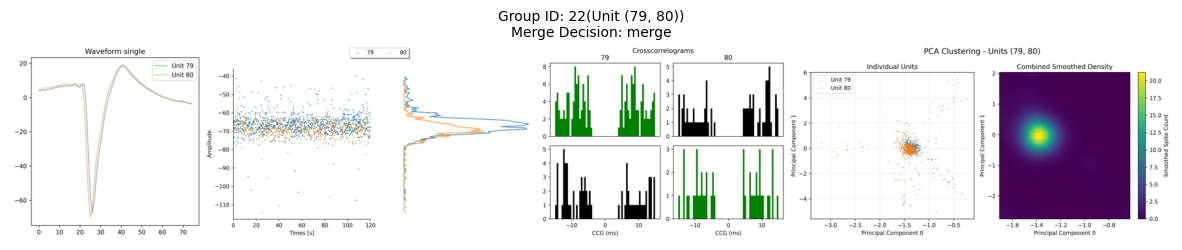

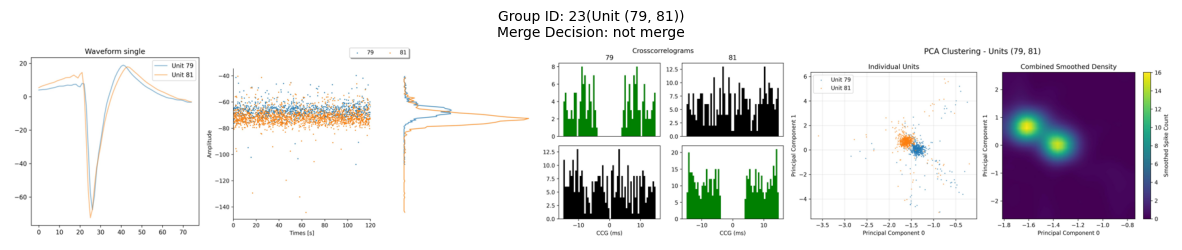

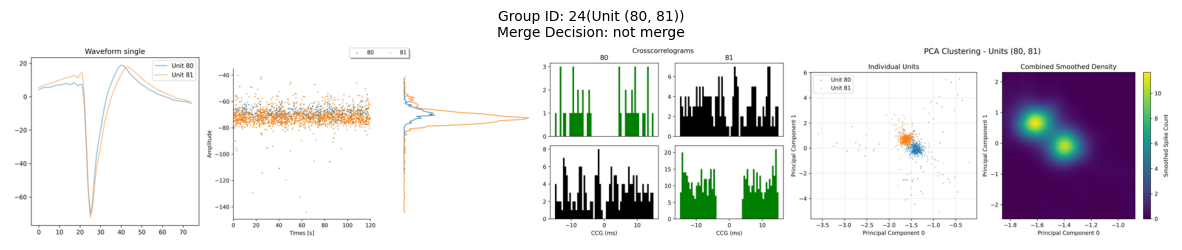

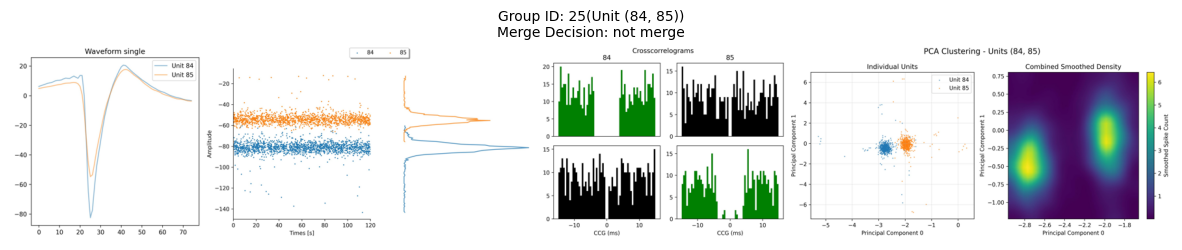

In [42]:
plot_merge_results(merge_results_df_fewshot, merge_img_df)

### Step 10.5: Examine Individual Merge Decisions

You can examine specific merge pairs in detail.

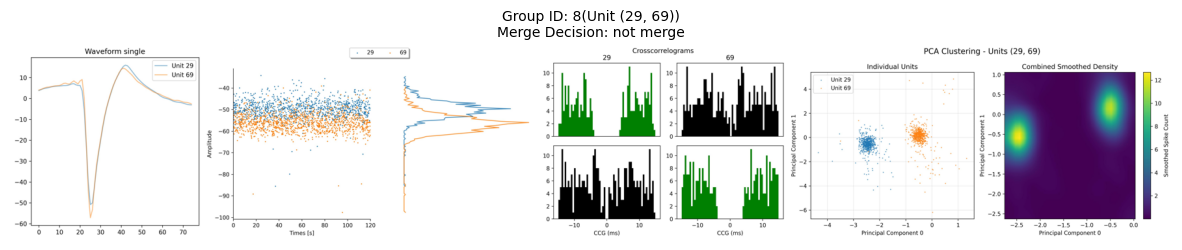

In [46]:
plot_merge_results(merge_results_df_fewshot[8:9], merge_img_df[8:9])

View the detailed reasoning for why a merge was accepted or rejected.

In [48]:
print(merge_results_df_fewshot.loc[8, 'reasoning'])

Start with CCG assessment: The crosscorrelogram report indicates a flat distribution with spikes present throughout, including around 0 ms, suggesting the units are from different neurons. This is a strong indicator against merging due to the lack of a refractory period dip. 

Supporting evidence from other modalities: The amplitude report suggests significant overlap, supporting a merge, and the waveform report indicates morphological consistency, also supporting a merge.

Final decision logic: Despite the supporting evidence from amplitude and waveform reports, the CCG report's indication of spikes in the refractory period is a critical factor. According to the decision strategy, this immediate rejection criterion overrides other evidence. Therefore, the units should not be merged.


---

## 11. Apply Merges

### Step 11.1: Execute Approved Merges

Apply all VLM-approved merges to create the final analyzer. The `resolve_merging_graph` function handles transitive merges (if A→B and B→C, then A→B→C should all merge).

In [49]:
if merge_results_df_fewshot is not None:
    merge_groups = merge_results_df_fewshot[merge_results_df_fewshot['merge_type'] == 'merge'].index.tolist()
    
    if len(merge_groups) > 0:
        from spikeinterface.curation.curation_tools import resolve_merging_graph
        
        merge_unit_pairs = [merge_results_df_fewshot.loc[group_idx, 'merge_units'] for group_idx in merge_groups]
        final_merge_groups = resolve_merging_graph(analyzer_curated.sorting, merge_unit_pairs)
        
        print("Applying merges...")
        print(f"Final merge groups: {final_merge_groups}")
        
        if final_merge_groups and len(final_merge_groups) > 0:
            merged_analyzer = analyzer_curated.merge_units(
                merge_unit_groups=final_merge_groups,
                sparsity_overlap=0
            )
            print(f"Created merged_analyzer with {len(merged_analyzer.unit_ids)} units")
            print(f"Original units: {len(analyzer_curated.unit_ids)}")
            print(f"Merged units: {len(merged_analyzer.unit_ids)}")
        else:
            print("No merges to apply after resolving merge graph.")
    else:
        print("No merges recommended. All units should be kept separate.")
else:
    print("No results available - no merge candidates were found.")

Applying merges...
Final merge groups: [[1, 3], [8, 10], [42, 43], [62, 63], [66, 67], [68, 69], [73, 74], [79, 80]]


calculate_pc_metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Created merged_analyzer with 32 units
Original units: 40
Merged units: 32


---

## 12. Evaluate Final Results

### Final Comparison with Ground Truth

Compare the final merged analyzer with ground truth to evaluate the complete pipeline.

**Key metrics to look for:**
- **Accuracy**: How many sorted units match ground truth units
- **Precision**: Proportion of detected units that are real
- **Recall**: Proportion of real units that were detected

The agreement matrix shows matches between sorted units (rows) and ground truth units (columns). High values on the diagonal indicate good performance.

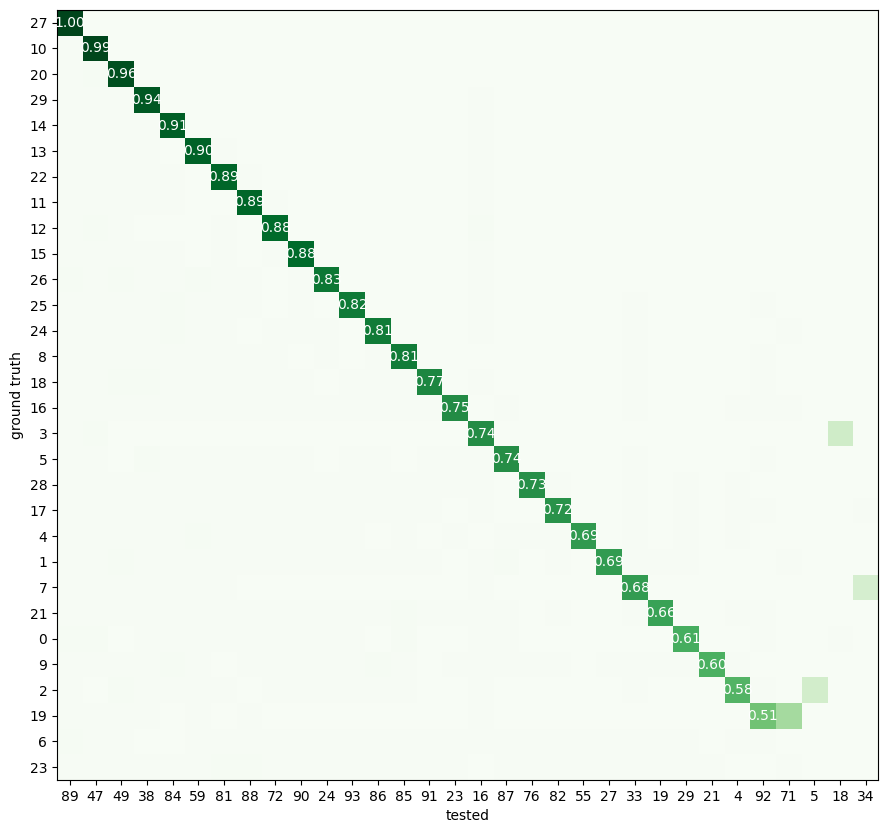

In [50]:
comp_gt_with_merged_analyzer= si.compare_sorter_to_ground_truth(gt_sorting=gt_sorting0, tested_sorting=merged_analyzer.sorting)
si.plot_agreement_matrix(comp_gt_with_merged_analyzer, figsize=(16, 10))

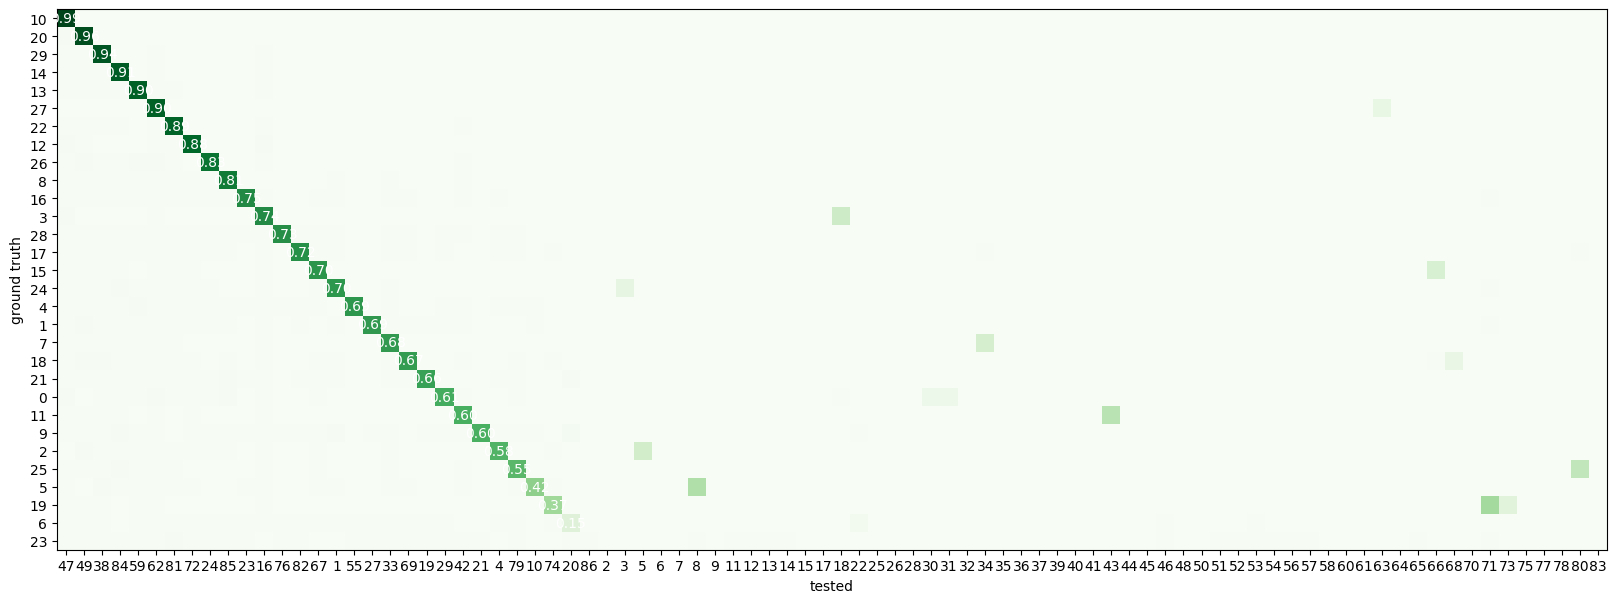

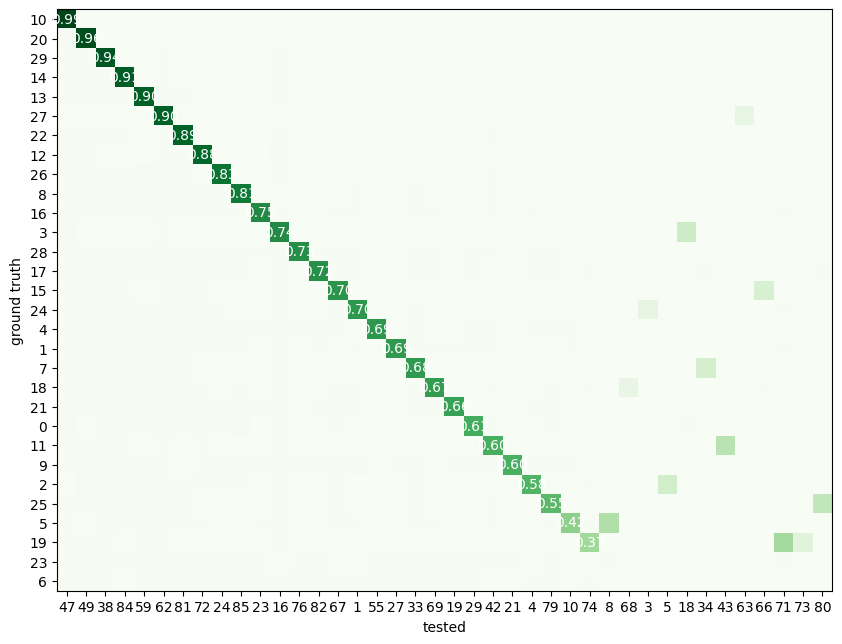

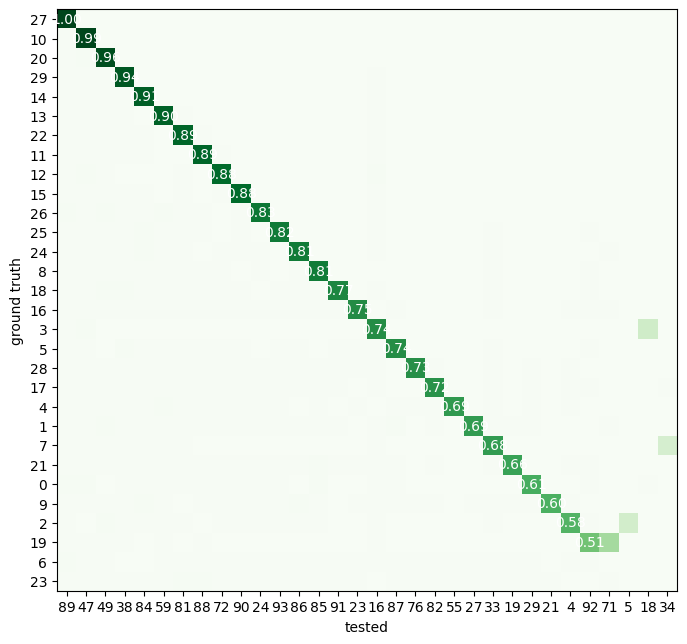

In [59]:
si.plot_agreement_matrix(comp_gt, figsize=(20, 10))
si.plot_agreement_matrix(comp_gt_curated, figsize=(10, 10))
si.plot_agreement_matrix(comp_gt_with_merged_analyzer, figsize=(8, 10))